In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import math 
from scipy.ndimage import zoom
from scipy.special import logsumexp


import os
import sys
import struct
import time

import pandas as pd
import seaborn as sns
import h5py

from tqdm import tqdm

%matplotlib inline

# Generating saliency maps for DeepGaze II and ICF (Intensity Contrast Feature) 

In [2]:
subject = "1"

In [3]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data"
BETAS_PATH = NSD_ROOT+f"/nsddata_betas/ppdata/subj0{subject}/func1pt8mm/betas_fithrf_GLMdenoise_RR/"
BEHAV_PATH = NSD_ROOT + f"/nsddata/ppdata/subj0{subject}/behav/responses.tsv"

DEVICE = 'cpu'

In [4]:
resp_subj1 = pd.read_csv(BEHAV_PATH, sep ='\t')
resp_subj1['73KID'] =  resp_subj1['73KID'] - 1
resp_subj1['10KID'] = resp_subj1['10KID'] -  1
resp_subj1.head()

,SUBJECT,SESSION,RUN,TRIAL,73KID,10KID,TIME,ISOLD,ISCORRECT,RT,CHANGEMIND,MEMORYRECENT,MEMORYFIRST,ISOLDCURRENT,ISCORRECTCURRENT,TOTAL1,TOTAL2,BUTTON,MISSINGDATA
0,1,1,1,1,46002,625,0.505082,0,1.0,803.529781,0.0,NaN,NaN,0,1.0,1,0,1.0,0
1,1,1,1,2,61882,5012,0.505128,0,1.0,972.261383,0.0,NaN,NaN,0,1.0,1,0,1.0,0
2,1,1,1,3,828,4849,0.505175,0,1.0,742.351236,0.0,NaN,NaN,0,1.0,1,0,1.0,0
3,1,1,1,4,67573,8822,0.505221,0,1.0,747.518479,0.0,NaN,NaN,0,1.0,1,0,1.0,0
4,1,1,1,5,16020,9537,0.505267,0,1.0,547.422774,0.0,NaN,NaN,0,1.0,1,0,1.0,0


In [5]:
img_indices = resp_subj1['73KID']
img_indices.shape

(30000,)

In [6]:
# Disable tensorflow 2.0 (DeepGazeII supports Tensorflow1)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

2023-09-12 12:04:08.702194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 12:04:08.895130: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-12 12:04:27.380536: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-12 12:04:27.380805: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [10]:
def gen_saliency_icf(image,model,channel_loc = 0):
    '''
    Generate saliency map using the ICF model  
    
    '''
    model = model 

    centerbias_template = np.load('../src/DeepGaze/centerbias_mit1003.npy')
    
    # Here Image is supposed to be [H x W x C] 
    # But NSD images are [C x H x W] 
        
        
    # Resize to match the size 
    if channel_loc == 0:
        centerbias = zoom(centerbias_template, (image.shape[1]/centerbias_template.shape[0], image.shape[2]/centerbias_template.shape[1]), order=0, mode='nearest')

    elif channel_loc == 2: 
        centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')

    centerbias -= logsumexp(centerbias)
    
    
    # Takes input Batch * Height * Width * Channel 
    
    if image.ndim == 3: # a single image
        image_data = image[np.newaxis, : , : , :]
        centerbias_data = centerbias[np.newaxis, :, :, np.newaxis] 
        
    elif image.ndim == 4: # a batch of images 
        image_data = image
        centerbias_data = centerbias[np.newaxis, :, :, np.newaxis] 

    
    # create image tensor with H x W x C dimensions 
    
    # if the image is of the shape [W x H x C] --> H x W x C    
   
    # print(centerbias.shape, centerbias_tensor.shape) 
    
    if model == 'deepgaze2': 
        check_point = 'DeepGazeII.ckpt' 
    elif model == 'icf':
        check_point = './checkpoints/ICF.ckpt' 
    else:
        raise Exception("Please provide a valid model name")
    
    new_saver = tf.train.import_meta_graph('{}.meta'.format(check_point))

    input_tensor = tf.get_collection('input_tensor')[0]
    centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
    log_density = tf.get_collection('log_density')[0]
    log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]
    
    
    with tf.Session() as sess:
    
        new_saver.restore(sess, check_point)

        log_density_prediction = sess.run(log_density, {
            input_tensor: image_data,
            centerbias_tensor: centerbias_data,
        })
        
    return log_density_prediction 

In [6]:
image_data_set = h5py.File(stim_file, 'r')

for key, value in image_data_set.items() :
    print(key,": \n", value,"\n")
    
image_data_73k = np.copy(image_data_set['imgBrick'])
image_data_set.close()

imgBrick : 
 <HDF5 dataset "imgBrick": shape (73000, 425, 425, 3), type "|u1"> 



In [12]:
img_test = image_data_73k[0]

In [13]:
sal_map_icf_test= gen_saliency_icf(img_test, 'icf', 2)

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


2023-09-12 12:06:08.241385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


2023-09-12 12:06:10.007278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:2f:00.0, compute capability: 7.5
2023-09-12 12:06:10.098134: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-09-12 12:06:12.662895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8302
2023-09-12 12:06:14.999828: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


In [14]:
# Run it batched 

img_indices_b = img_indices[:5]
imgs_b = image_data_73k[img_indices_b]

In [15]:
sal_maps_icf_b = gen_saliency_icf(imgs_b, 'icf', 2)

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


2023-09-12 12:06:32.311273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:2f:00.0, compute capability: 7.5


In [16]:
sal_maps_icf_b.shape

(5, 425, 425, 1)

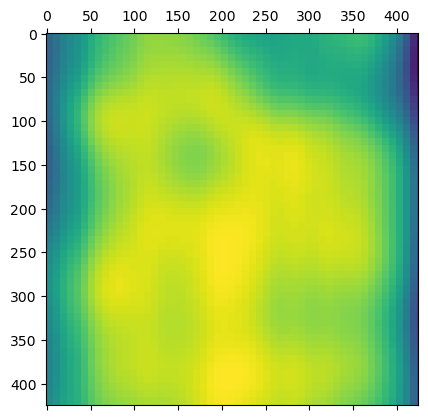

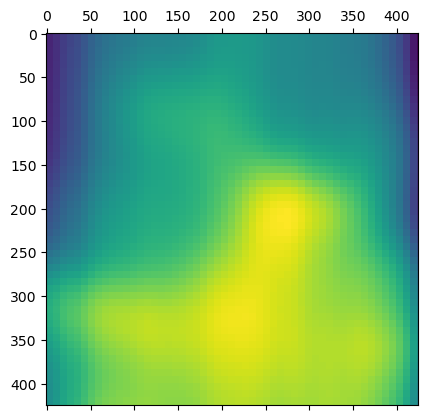

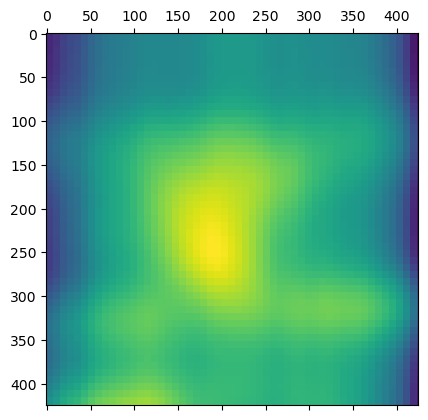

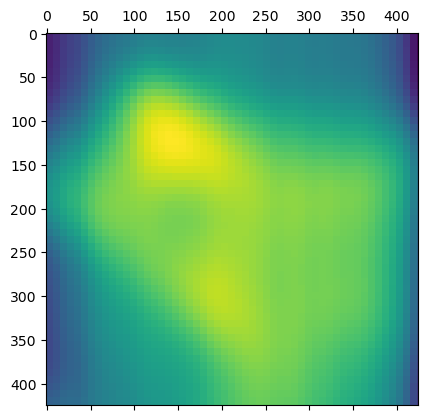

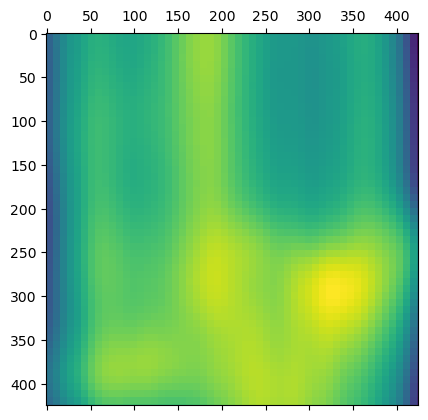

In [17]:
for idx in range(sal_maps_icf_b.shape[0]): 
    sal_map = sal_maps_icf_b[idx]
    plt.matshow(sal_map[:,:,0])


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


2023-09-11 15:47:29.305804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:2f:00.0, compute capability: 7.5


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


2023-09-11 15:47:32.543735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:2f:00.0, compute capability: 7.5


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


2023-09-11 15:47:36.021783: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:2f:00.0, compute capability: 7.5


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


2023-09-11 15:47:40.045625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:2f:00.0, compute capability: 7.5


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


2023-09-11 15:47:44.274539: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:2f:00.0, compute capability: 7.5


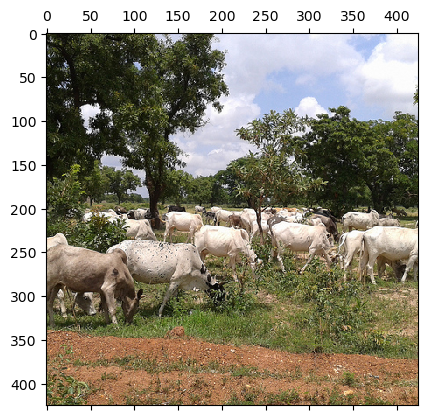

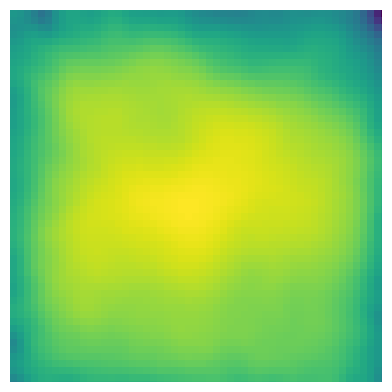

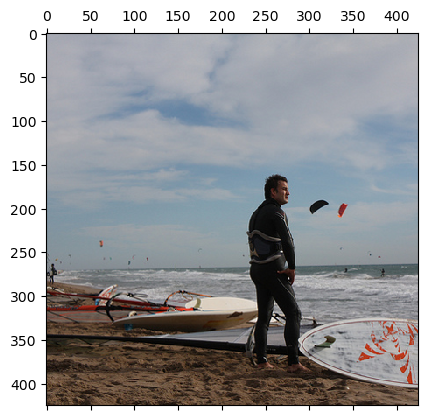

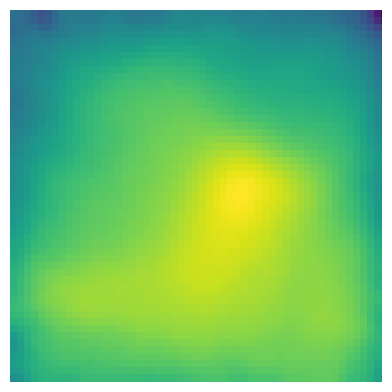

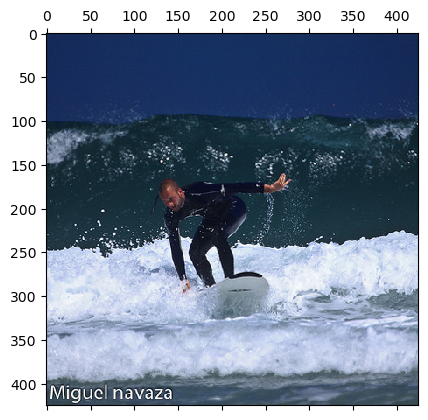

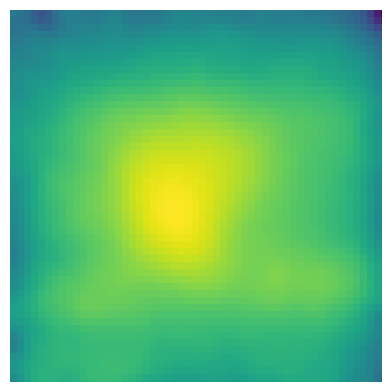

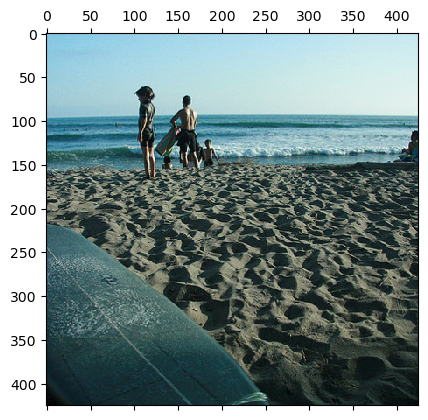

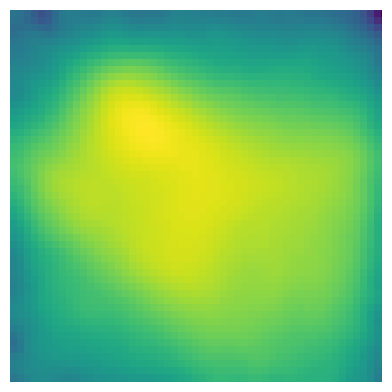

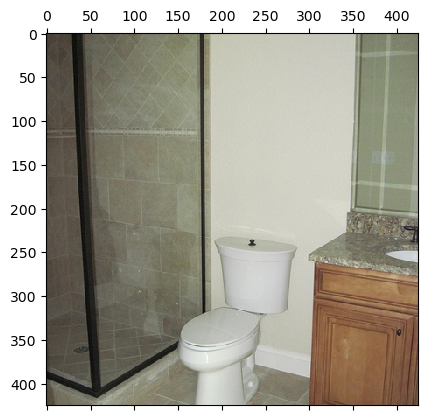

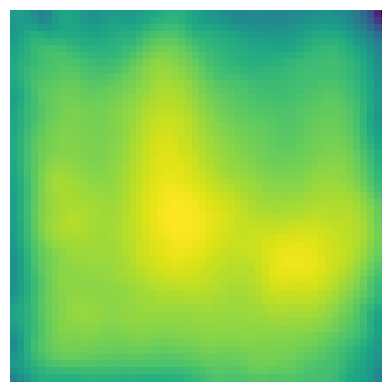

In [16]:
for idx in img_indices[:5]: 
    image = image_data_73k[idx] 
    plt.matshow(image_data_73k[idx])
    
    sal_map_icf= gen_saliency_icf(image, 'icf', 2)
    plt.matshow(sal_map_icf[0,:,:,0])
    plt.axis('off')



In [18]:
# Generate first a unique index of images as shown to the participant. since each image is shown 3 times, 
# the resulting dictionary should have 10,000 images (i.e. 30,000 / 3) 
# this index is then used to create the input images to the model 
    
imgs_processed = {} 

for idx in tqdm(img_indices): 
    if idx in imgs_processed:
        continue 
    else:
        imgs_processed[idx] = idx
        
unique_img_indices = list(imgs_processed)

100%|██████████| 30000/30000 [00:00<00:00, 1458296.58it/s]


In [41]:
def generate_maps_ICF_fix_sess(sess, uniqe_img_indices, model, batch_size = 8): 
    
    '''
    Generate saliency maps with either ICF/DeepGaze 2 model. 
    The input images are of the shape: (batch_size x width x height x channel)
    '''
    
    num_pixels = 425 
    centerbias_template = np.load('../src/DeepGaze/centerbias_mit1003.npy')
    centerbias = zoom(centerbias_template, (num_pixels/centerbias_template.shape[0], num_pixels/centerbias_template.shape[1]), order=0, mode='nearest')
    centerbias -= logsumexp(centerbias)
    centerbias_data = centerbias[np.newaxis, :, :, np.newaxis] 


    S_mat_full = np.ones([len(uniqe_img_indices), 425 , 425], dtype = 'float16')    
    batch_size = batch_size 
    
    if model == 'deepgaze2': 
        check_point = './checkpoints/DeepGazeII.ckpt' 
    elif model == 'icf':
        check_point = './checkpoints/ICF.ckpt' 
    else:
        raise Exception("Please provide a valid model name")
        
    new_saver = tf.train.import_meta_graph('{}.meta'.format(check_point))

    input_tensor = tf.get_collection('input_tensor')[0]
    centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
    log_density = tf.get_collection('log_density')[0]
    log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]
    
    
    for indices in tqdm(range(0,len(uniqe_img_indices), batch_size)): 
        
        chunk = uniqe_img_indices[indices:indices+batch_size]
        images = image_data_73k[chunk] 
        
        new_saver.restore(sess, check_point)

        log_density_prediction = sess.run(log_density, {
            input_tensor: images,
            centerbias_tensor: centerbias_data,
        })
                          
        S_mat_full[indices:indices+batch_size, :] = log_density_prediction[:, :, :, 0]
                              
    return S_mat_full

In [43]:
with tf.Session() as sess:
    sal_maps_icf_all = generate_maps_ICF_fix_sess(sess = sess, uniqe_img_indices =unique_img_indices, model = 'icf' , batch_size = 8)

2023-09-12 13:55:08.426655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:2f:00.0, compute capability: 7.5


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


  0%|          | 0/1250 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  0%|          | 1/1250 [00:09<3:10:14,  9.14s/it]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  0%|          | 3/1250 [00:09<50:16,  2.42s/it]  

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  0%|          | 5/1250 [00:09<25:05,  1.21s/it]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  1%|          | 7/1250 [00:09<15:00,  1.38it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  1%|          | 9/1250 [00:09<09:50,  2.10it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  1%|          | 11/1250 [00:09<06:52,  3.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  1%|          | 13/1250 [00:09<05:01,  4.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  1%|          | 15/1250 [00:10<03:49,  5.38it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  1%|▏         | 17/1250 [00:10<03:02,  6.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  2%|▏         | 19/1250 [00:10<02:30,  8.15it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  2%|▏         | 21/1250 [00:10<02:09,  9.48it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  2%|▏         | 23/1250 [00:10<01:55, 10.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  2%|▏         | 25/1250 [00:10<01:44, 11.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  2%|▏         | 27/1250 [00:10<01:37, 12.57it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  2%|▏         | 29/1250 [00:10<01:32, 13.26it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  2%|▏         | 31/1250 [00:11<01:27, 13.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  3%|▎         | 33/1250 [00:11<01:24, 14.39it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  3%|▎         | 35/1250 [00:11<01:22, 14.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  3%|▎         | 37/1250 [00:11<01:22, 14.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  3%|▎         | 39/1250 [00:11<01:21, 14.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  3%|▎         | 41/1250 [00:11<01:20, 14.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  3%|▎         | 43/1250 [00:11<01:19, 15.25it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  4%|▎         | 45/1250 [00:12<01:18, 15.36it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  4%|▍         | 47/1250 [00:12<01:18, 15.31it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  4%|▍         | 49/1250 [00:12<01:18, 15.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  4%|▍         | 51/1250 [00:12<01:17, 15.45it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  4%|▍         | 53/1250 [00:12<01:17, 15.38it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  4%|▍         | 55/1250 [00:12<01:17, 15.43it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  5%|▍         | 57/1250 [00:12<01:17, 15.41it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  5%|▍         | 59/1250 [00:12<01:17, 15.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  5%|▍         | 61/1250 [00:13<01:15, 15.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  5%|▌         | 63/1250 [00:13<01:15, 15.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  5%|▌         | 65/1250 [00:13<01:16, 15.49it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  5%|▌         | 67/1250 [00:13<01:15, 15.58it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  6%|▌         | 69/1250 [00:13<01:16, 15.49it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  6%|▌         | 71/1250 [00:13<01:17, 15.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  6%|▌         | 73/1250 [00:13<01:16, 15.46it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  6%|▌         | 75/1250 [00:13<01:15, 15.47it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  6%|▌         | 77/1250 [00:14<01:16, 15.36it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  6%|▋         | 79/1250 [00:14<01:16, 15.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  6%|▋         | 81/1250 [00:14<01:16, 15.34it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  7%|▋         | 83/1250 [00:14<01:15, 15.37it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  7%|▋         | 85/1250 [00:14<01:16, 15.27it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  7%|▋         | 87/1250 [00:14<01:14, 15.52it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  7%|▋         | 89/1250 [00:14<01:15, 15.44it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  7%|▋         | 91/1250 [00:15<01:15, 15.31it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  7%|▋         | 93/1250 [00:15<01:16, 15.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  8%|▊         | 95/1250 [00:15<01:17, 14.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  8%|▊         | 97/1250 [00:15<01:17, 14.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  8%|▊         | 99/1250 [00:15<01:16, 15.10it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  8%|▊         | 101/1250 [00:15<01:15, 15.19it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  8%|▊         | 103/1250 [00:15<01:15, 15.12it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  8%|▊         | 105/1250 [00:15<01:15, 15.17it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  9%|▊         | 107/1250 [00:16<01:14, 15.27it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  9%|▊         | 109/1250 [00:16<01:14, 15.25it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  9%|▉         | 111/1250 [00:16<01:14, 15.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  9%|▉         | 113/1250 [00:16<01:14, 15.31it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  9%|▉         | 115/1250 [00:16<01:14, 15.27it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


  9%|▉         | 117/1250 [00:16<01:14, 15.17it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 10%|▉         | 119/1250 [00:16<01:14, 15.25it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 10%|▉         | 121/1250 [00:16<01:14, 15.23it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 10%|▉         | 123/1250 [00:17<01:14, 15.18it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 10%|█         | 125/1250 [00:17<01:14, 15.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 10%|█         | 127/1250 [00:17<01:13, 15.30it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 10%|█         | 129/1250 [00:17<01:13, 15.31it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 10%|█         | 131/1250 [00:17<01:12, 15.53it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 11%|█         | 133/1250 [00:17<01:12, 15.46it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 11%|█         | 135/1250 [00:17<01:12, 15.43it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 11%|█         | 137/1250 [00:18<01:12, 15.26it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 11%|█         | 139/1250 [00:18<01:12, 15.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 11%|█▏        | 141/1250 [00:18<01:12, 15.32it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 11%|█▏        | 143/1250 [00:18<01:11, 15.39it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 12%|█▏        | 145/1250 [00:18<01:12, 15.34it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 12%|█▏        | 147/1250 [00:18<01:11, 15.48it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 12%|█▏        | 149/1250 [00:18<01:11, 15.48it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 12%|█▏        | 151/1250 [00:18<01:11, 15.46it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 12%|█▏        | 153/1250 [00:19<01:10, 15.51it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 12%|█▏        | 155/1250 [00:19<01:10, 15.58it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 13%|█▎        | 157/1250 [00:19<01:11, 15.39it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 13%|█▎        | 159/1250 [00:19<01:11, 15.32it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 13%|█▎        | 161/1250 [00:19<01:11, 15.26it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 13%|█▎        | 163/1250 [00:19<01:11, 15.13it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 13%|█▎        | 165/1250 [00:19<01:11, 15.19it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 13%|█▎        | 167/1250 [00:19<01:10, 15.31it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 14%|█▎        | 169/1250 [00:20<01:10, 15.30it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 14%|█▎        | 171/1250 [00:20<01:10, 15.28it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 14%|█▍        | 173/1250 [00:20<01:10, 15.18it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 14%|█▍        | 175/1250 [00:20<01:11, 15.10it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 14%|█▍        | 177/1250 [00:20<01:09, 15.50it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 14%|█▍        | 179/1250 [00:20<01:09, 15.49it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 14%|█▍        | 181/1250 [00:20<01:08, 15.50it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 15%|█▍        | 183/1250 [00:21<01:09, 15.30it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 15%|█▍        | 185/1250 [00:21<01:09, 15.26it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 15%|█▍        | 187/1250 [00:21<01:10, 15.14it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 15%|█▌        | 189/1250 [00:21<01:10, 15.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 15%|█▌        | 191/1250 [00:21<01:09, 15.32it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 15%|█▌        | 193/1250 [00:21<01:08, 15.42it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 16%|█▌        | 195/1250 [00:21<01:07, 15.54it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 16%|█▌        | 197/1250 [00:21<01:07, 15.58it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 16%|█▌        | 199/1250 [00:22<01:08, 15.41it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 16%|█▌        | 201/1250 [00:22<01:08, 15.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 16%|█▌        | 203/1250 [00:22<01:10, 14.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 16%|█▋        | 205/1250 [00:22<01:10, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 17%|█▋        | 207/1250 [00:22<01:11, 14.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 17%|█▋        | 209/1250 [00:22<01:10, 14.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 17%|█▋        | 211/1250 [00:22<01:11, 14.52it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 17%|█▋        | 213/1250 [00:23<01:11, 14.59it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 17%|█▋        | 215/1250 [00:23<01:11, 14.51it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 17%|█▋        | 217/1250 [00:23<01:11, 14.40it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 18%|█▊        | 219/1250 [00:23<01:12, 14.15it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 18%|█▊        | 221/1250 [00:23<01:11, 14.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 18%|█▊        | 223/1250 [00:23<01:10, 14.58it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 18%|█▊        | 225/1250 [00:23<01:09, 14.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 18%|█▊        | 227/1250 [00:24<01:10, 14.56it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 18%|█▊        | 229/1250 [00:24<01:10, 14.44it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 18%|█▊        | 231/1250 [00:24<01:09, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 19%|█▊        | 233/1250 [00:24<01:08, 14.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 19%|█▉        | 235/1250 [00:24<01:08, 14.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 19%|█▉        | 237/1250 [00:24<01:08, 14.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 19%|█▉        | 239/1250 [00:24<01:07, 15.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 19%|█▉        | 241/1250 [00:24<01:07, 15.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 19%|█▉        | 243/1250 [00:25<01:06, 15.12it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 20%|█▉        | 245/1250 [00:25<01:06, 15.20it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 20%|█▉        | 247/1250 [00:25<01:06, 15.18it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 20%|█▉        | 249/1250 [00:25<01:05, 15.19it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 20%|██        | 251/1250 [00:25<01:05, 15.23it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 20%|██        | 253/1250 [00:25<01:05, 15.27it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 20%|██        | 255/1250 [00:25<01:05, 15.21it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 21%|██        | 257/1250 [00:25<01:05, 15.24it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 21%|██        | 259/1250 [00:26<01:04, 15.27it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 21%|██        | 261/1250 [00:26<01:06, 14.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 21%|██        | 263/1250 [00:26<01:05, 15.13it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 21%|██        | 265/1250 [00:26<01:05, 15.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 21%|██▏       | 267/1250 [00:26<01:05, 15.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 22%|██▏       | 269/1250 [00:26<01:04, 15.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 22%|██▏       | 271/1250 [00:26<01:04, 15.16it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 22%|██▏       | 273/1250 [00:27<01:04, 15.13it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 22%|██▏       | 275/1250 [00:27<01:05, 14.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 22%|██▏       | 277/1250 [00:27<01:05, 14.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 22%|██▏       | 279/1250 [00:27<01:05, 14.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 22%|██▏       | 281/1250 [00:27<01:04, 15.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 23%|██▎       | 283/1250 [00:27<01:04, 14.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 23%|██▎       | 285/1250 [00:27<01:04, 14.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 23%|██▎       | 287/1250 [00:27<01:04, 14.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 23%|██▎       | 289/1250 [00:28<01:04, 14.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 23%|██▎       | 291/1250 [00:28<01:04, 14.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 23%|██▎       | 293/1250 [00:28<01:04, 14.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 24%|██▎       | 295/1250 [00:28<01:03, 14.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 24%|██▍       | 297/1250 [00:28<01:03, 15.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 24%|██▍       | 299/1250 [00:28<01:03, 15.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 24%|██▍       | 301/1250 [00:28<01:06, 14.23it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 24%|██▍       | 303/1250 [00:29<01:05, 14.56it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 24%|██▍       | 305/1250 [00:29<01:06, 14.32it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 25%|██▍       | 307/1250 [00:29<01:05, 14.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 25%|██▍       | 309/1250 [00:29<01:04, 14.58it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 25%|██▍       | 311/1250 [00:29<01:03, 14.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 25%|██▌       | 313/1250 [00:29<01:02, 14.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 25%|██▌       | 315/1250 [00:29<01:02, 15.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 25%|██▌       | 317/1250 [00:30<01:01, 15.19it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 26%|██▌       | 319/1250 [00:30<01:01, 15.15it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 26%|██▌       | 321/1250 [00:30<01:01, 15.19it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 26%|██▌       | 323/1250 [00:30<01:01, 15.12it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 26%|██▌       | 325/1250 [00:30<01:00, 15.28it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 26%|██▌       | 327/1250 [00:30<01:00, 15.20it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 26%|██▋       | 329/1250 [00:30<01:01, 15.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 26%|██▋       | 331/1250 [00:30<01:01, 15.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 27%|██▋       | 333/1250 [00:31<01:00, 15.15it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 27%|██▋       | 335/1250 [00:31<00:59, 15.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 27%|██▋       | 337/1250 [00:31<00:59, 15.27it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 27%|██▋       | 339/1250 [00:31<01:00, 15.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 27%|██▋       | 341/1250 [00:31<00:59, 15.38it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 27%|██▋       | 343/1250 [00:31<00:59, 15.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 28%|██▊       | 345/1250 [00:31<00:58, 15.49it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 28%|██▊       | 347/1250 [00:31<00:58, 15.51it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 28%|██▊       | 349/1250 [00:32<00:56, 15.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 28%|██▊       | 351/1250 [00:32<00:56, 15.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 28%|██▊       | 353/1250 [00:32<00:57, 15.69it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 28%|██▊       | 355/1250 [00:32<00:57, 15.64it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 29%|██▊       | 357/1250 [00:32<00:57, 15.59it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 29%|██▊       | 359/1250 [00:32<00:57, 15.43it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 29%|██▉       | 361/1250 [00:32<00:58, 15.17it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 29%|██▉       | 363/1250 [00:33<00:58, 15.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 29%|██▉       | 365/1250 [00:33<00:58, 15.23it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 29%|██▉       | 367/1250 [00:33<00:58, 15.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 30%|██▉       | 369/1250 [00:33<00:58, 15.16it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 30%|██▉       | 371/1250 [00:33<00:57, 15.20it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 30%|██▉       | 373/1250 [00:33<00:58, 15.12it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 30%|███       | 375/1250 [00:33<00:57, 15.14it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 30%|███       | 377/1250 [00:33<00:57, 15.15it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 30%|███       | 379/1250 [00:34<00:58, 14.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 30%|███       | 381/1250 [00:34<00:58, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 31%|███       | 383/1250 [00:34<00:59, 14.64it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 31%|███       | 385/1250 [00:34<00:59, 14.55it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 31%|███       | 387/1250 [00:34<00:58, 14.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 31%|███       | 389/1250 [00:34<00:58, 14.61it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 31%|███▏      | 391/1250 [00:34<00:59, 14.52it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 31%|███▏      | 393/1250 [00:35<00:59, 14.42it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 32%|███▏      | 395/1250 [00:35<00:59, 14.38it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 32%|███▏      | 397/1250 [00:35<00:59, 14.43it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 32%|███▏      | 399/1250 [00:35<01:01, 13.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 32%|███▏      | 401/1250 [00:35<01:02, 13.53it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 32%|███▏      | 403/1250 [00:35<01:04, 13.19it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 32%|███▏      | 405/1250 [00:35<01:02, 13.61it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 33%|███▎      | 407/1250 [00:36<01:00, 13.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 33%|███▎      | 409/1250 [00:36<00:59, 14.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 33%|███▎      | 411/1250 [00:36<00:58, 14.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 33%|███▎      | 413/1250 [00:36<00:57, 14.48it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 33%|███▎      | 415/1250 [00:36<00:57, 14.64it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 33%|███▎      | 417/1250 [00:36<00:56, 14.63it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 34%|███▎      | 419/1250 [00:36<00:56, 14.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 34%|███▎      | 421/1250 [00:37<00:56, 14.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 34%|███▍      | 423/1250 [00:37<00:56, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 34%|███▍      | 425/1250 [00:37<00:55, 14.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 34%|███▍      | 427/1250 [00:37<00:55, 14.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 34%|███▍      | 429/1250 [00:37<00:55, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 34%|███▍      | 431/1250 [00:37<00:55, 14.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 35%|███▍      | 433/1250 [00:37<00:54, 14.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 35%|███▍      | 435/1250 [00:37<00:54, 14.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 35%|███▍      | 437/1250 [00:38<00:54, 14.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 35%|███▌      | 439/1250 [00:38<00:54, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 35%|███▌      | 441/1250 [00:38<00:54, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 35%|███▌      | 443/1250 [00:38<00:54, 14.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 36%|███▌      | 445/1250 [00:38<00:54, 14.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 36%|███▌      | 447/1250 [00:38<00:54, 14.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 36%|███▌      | 449/1250 [00:38<00:54, 14.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 36%|███▌      | 451/1250 [00:39<00:53, 14.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 36%|███▌      | 453/1250 [00:39<00:53, 15.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 36%|███▋      | 455/1250 [00:39<00:52, 15.08it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 37%|███▋      | 457/1250 [00:39<00:52, 15.19it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 37%|███▋      | 459/1250 [00:39<00:52, 15.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 37%|███▋      | 461/1250 [00:39<00:53, 14.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 37%|███▋      | 463/1250 [00:39<00:53, 14.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 37%|███▋      | 465/1250 [00:39<00:53, 14.58it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 37%|███▋      | 467/1250 [00:40<00:53, 14.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 38%|███▊      | 469/1250 [00:40<00:52, 14.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 38%|███▊      | 471/1250 [00:40<00:52, 14.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 38%|███▊      | 473/1250 [00:40<00:52, 14.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 38%|███▊      | 475/1250 [00:40<00:52, 14.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 38%|███▊      | 477/1250 [00:40<00:51, 15.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 38%|███▊      | 479/1250 [00:40<00:51, 15.09it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 38%|███▊      | 481/1250 [00:41<00:51, 14.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 39%|███▊      | 483/1250 [00:41<00:51, 15.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 39%|███▉      | 485/1250 [00:41<00:50, 15.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 39%|███▉      | 487/1250 [00:41<00:50, 15.14it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 39%|███▉      | 489/1250 [00:41<00:50, 15.12it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 39%|███▉      | 491/1250 [00:41<00:50, 15.15it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 39%|███▉      | 493/1250 [00:41<00:50, 15.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 40%|███▉      | 495/1250 [00:41<00:50, 14.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 40%|███▉      | 497/1250 [00:42<00:50, 15.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 40%|███▉      | 499/1250 [00:42<00:49, 15.09it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 40%|████      | 501/1250 [00:42<00:49, 15.16it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 40%|████      | 503/1250 [00:42<00:49, 15.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 40%|████      | 505/1250 [00:42<00:50, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 41%|████      | 507/1250 [00:42<00:49, 14.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 41%|████      | 509/1250 [00:42<00:49, 14.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 41%|████      | 511/1250 [00:43<00:49, 15.08it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 41%|████      | 513/1250 [00:43<00:49, 15.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 41%|████      | 515/1250 [00:43<00:48, 15.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 41%|████▏     | 517/1250 [00:43<00:49, 14.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 42%|████▏     | 519/1250 [00:43<00:49, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 42%|████▏     | 521/1250 [00:43<00:49, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 42%|████▏     | 523/1250 [00:43<00:48, 14.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 42%|████▏     | 525/1250 [00:43<00:48, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 42%|████▏     | 527/1250 [00:44<00:48, 14.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 42%|████▏     | 529/1250 [00:44<00:48, 14.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 42%|████▏     | 531/1250 [00:44<00:48, 14.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 43%|████▎     | 533/1250 [00:44<00:48, 14.69it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 43%|████▎     | 535/1250 [00:44<00:48, 14.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 43%|████▎     | 537/1250 [00:44<00:48, 14.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 43%|████▎     | 539/1250 [00:44<00:47, 14.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 43%|████▎     | 541/1250 [00:45<00:47, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 43%|████▎     | 543/1250 [00:45<00:47, 14.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 44%|████▎     | 545/1250 [00:45<00:47, 14.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 44%|████▍     | 547/1250 [00:45<00:47, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 44%|████▍     | 549/1250 [00:45<00:47, 14.62it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 44%|████▍     | 551/1250 [00:45<00:47, 14.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 44%|████▍     | 553/1250 [00:45<00:47, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 44%|████▍     | 555/1250 [00:46<00:47, 14.61it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 45%|████▍     | 557/1250 [00:46<00:46, 14.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 45%|████▍     | 559/1250 [00:46<00:46, 14.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 45%|████▍     | 561/1250 [00:46<00:46, 14.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 45%|████▌     | 563/1250 [00:46<00:46, 14.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 45%|████▌     | 565/1250 [00:46<00:45, 14.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 45%|████▌     | 567/1250 [00:46<00:45, 15.13it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 46%|████▌     | 569/1250 [00:46<00:44, 15.15it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 46%|████▌     | 571/1250 [00:47<00:45, 14.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 46%|████▌     | 573/1250 [00:47<00:45, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 46%|████▌     | 575/1250 [00:47<00:44, 15.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 46%|████▌     | 577/1250 [00:47<00:44, 15.21it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 46%|████▋     | 579/1250 [00:47<00:44, 15.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 46%|████▋     | 581/1250 [00:47<00:44, 15.08it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 47%|████▋     | 583/1250 [00:47<00:44, 15.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 47%|████▋     | 585/1250 [00:48<00:43, 15.14it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 47%|████▋     | 587/1250 [00:48<00:44, 14.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 47%|████▋     | 589/1250 [00:48<00:44, 14.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 47%|████▋     | 591/1250 [00:48<00:44, 14.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 47%|████▋     | 593/1250 [00:48<00:44, 14.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 48%|████▊     | 595/1250 [00:48<00:44, 14.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 48%|████▊     | 597/1250 [00:48<00:44, 14.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 48%|████▊     | 599/1250 [00:48<00:43, 14.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 48%|████▊     | 601/1250 [00:49<00:43, 14.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 48%|████▊     | 603/1250 [00:49<00:43, 14.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 48%|████▊     | 605/1250 [00:49<00:43, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 49%|████▊     | 607/1250 [00:49<00:43, 14.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 49%|████▊     | 609/1250 [00:49<00:43, 14.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 49%|████▉     | 611/1250 [00:49<00:43, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 49%|████▉     | 613/1250 [00:49<00:43, 14.54it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 49%|████▉     | 615/1250 [00:50<00:43, 14.64it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 49%|████▉     | 617/1250 [00:50<00:42, 14.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 50%|████▉     | 619/1250 [00:50<00:42, 14.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 50%|████▉     | 621/1250 [00:50<00:42, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 50%|████▉     | 623/1250 [00:50<00:42, 14.68it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 50%|█████     | 625/1250 [00:50<00:42, 14.61it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 50%|█████     | 627/1250 [00:50<00:42, 14.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 50%|█████     | 629/1250 [00:51<00:42, 14.53it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 50%|█████     | 631/1250 [00:51<00:42, 14.44it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 51%|█████     | 633/1250 [00:51<00:42, 14.36it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 51%|█████     | 635/1250 [00:51<00:43, 14.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 51%|█████     | 637/1250 [00:51<00:42, 14.44it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 51%|█████     | 639/1250 [00:51<00:42, 14.43it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 51%|█████▏    | 641/1250 [00:51<00:42, 14.36it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 51%|█████▏    | 643/1250 [00:51<00:41, 14.56it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 52%|█████▏    | 645/1250 [00:52<00:42, 14.28it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 52%|█████▏    | 647/1250 [00:52<00:41, 14.44it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 52%|█████▏    | 649/1250 [00:52<00:41, 14.60it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 52%|█████▏    | 651/1250 [00:52<00:40, 14.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 52%|█████▏    | 653/1250 [00:52<00:40, 14.63it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 52%|█████▏    | 655/1250 [00:52<00:40, 14.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 53%|█████▎    | 657/1250 [00:52<00:40, 14.61it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 53%|█████▎    | 659/1250 [00:53<00:40, 14.55it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 53%|█████▎    | 661/1250 [00:53<00:40, 14.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 53%|█████▎    | 663/1250 [00:53<00:39, 14.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 53%|█████▎    | 665/1250 [00:53<00:39, 14.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 53%|█████▎    | 667/1250 [00:53<00:39, 14.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 54%|█████▎    | 669/1250 [00:53<00:39, 14.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 54%|█████▎    | 671/1250 [00:53<00:39, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 54%|█████▍    | 673/1250 [00:54<00:38, 14.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 54%|█████▍    | 675/1250 [00:54<00:38, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 54%|█████▍    | 677/1250 [00:54<00:38, 15.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 54%|█████▍    | 679/1250 [00:54<00:37, 15.09it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 54%|█████▍    | 681/1250 [00:54<00:37, 15.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 55%|█████▍    | 683/1250 [00:54<00:38, 14.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 55%|█████▍    | 685/1250 [00:54<00:38, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 55%|█████▍    | 687/1250 [00:54<00:37, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 55%|█████▌    | 689/1250 [00:55<00:37, 14.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 55%|█████▌    | 691/1250 [00:55<00:38, 14.68it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 55%|█████▌    | 693/1250 [00:55<00:38, 14.63it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 56%|█████▌    | 695/1250 [00:55<00:38, 14.58it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 56%|█████▌    | 697/1250 [00:55<00:37, 14.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 56%|█████▌    | 699/1250 [00:55<00:37, 14.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 56%|█████▌    | 701/1250 [00:55<00:37, 14.46it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 56%|█████▌    | 703/1250 [00:56<00:38, 14.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 56%|█████▋    | 705/1250 [00:56<00:38, 14.23it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 57%|█████▋    | 707/1250 [00:56<00:38, 13.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 57%|█████▋    | 709/1250 [00:56<00:38, 13.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 57%|█████▋    | 711/1250 [00:56<00:37, 14.26it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 57%|█████▋    | 713/1250 [00:56<00:37, 14.39it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 57%|█████▋    | 715/1250 [00:56<00:36, 14.61it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 57%|█████▋    | 717/1250 [00:57<00:36, 14.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 58%|█████▊    | 719/1250 [00:57<00:35, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 58%|█████▊    | 721/1250 [00:57<00:35, 14.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 58%|█████▊    | 723/1250 [00:57<00:35, 14.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 58%|█████▊    | 725/1250 [00:57<00:35, 14.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 58%|█████▊    | 727/1250 [00:57<00:34, 14.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 58%|█████▊    | 729/1250 [00:57<00:35, 14.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 58%|█████▊    | 731/1250 [00:57<00:35, 14.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 59%|█████▊    | 733/1250 [00:58<00:34, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 59%|█████▉    | 735/1250 [00:58<00:34, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 59%|█████▉    | 737/1250 [00:58<00:34, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 59%|█████▉    | 739/1250 [00:58<00:34, 14.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 59%|█████▉    | 741/1250 [00:58<00:34, 14.60it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 59%|█████▉    | 743/1250 [00:58<00:34, 14.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 60%|█████▉    | 745/1250 [00:58<00:34, 14.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 60%|█████▉    | 747/1250 [00:59<00:33, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 60%|█████▉    | 749/1250 [00:59<00:33, 14.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 60%|██████    | 751/1250 [00:59<00:33, 14.68it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 60%|██████    | 753/1250 [00:59<00:33, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 60%|██████    | 755/1250 [00:59<00:33, 14.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 61%|██████    | 757/1250 [00:59<00:33, 14.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 61%|██████    | 759/1250 [00:59<00:33, 14.55it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 61%|██████    | 761/1250 [01:00<00:33, 14.46it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 61%|██████    | 763/1250 [01:00<00:33, 14.38it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 61%|██████    | 765/1250 [01:00<00:33, 14.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 61%|██████▏   | 767/1250 [01:00<00:33, 14.36it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 62%|██████▏   | 769/1250 [01:00<00:34, 13.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 62%|██████▏   | 771/1250 [01:00<00:33, 14.17it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 62%|██████▏   | 773/1250 [01:00<00:36, 13.13it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 62%|██████▏   | 775/1250 [01:01<00:36, 13.12it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 62%|██████▏   | 777/1250 [01:01<00:36, 12.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 62%|██████▏   | 779/1250 [01:01<00:37, 12.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 62%|██████▏   | 781/1250 [01:01<00:35, 13.21it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 63%|██████▎   | 783/1250 [01:01<00:34, 13.59it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 63%|██████▎   | 785/1250 [01:01<00:33, 14.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 63%|██████▎   | 787/1250 [01:01<00:32, 14.35it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 63%|██████▎   | 789/1250 [01:02<00:31, 14.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 63%|██████▎   | 791/1250 [01:02<00:31, 14.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 63%|██████▎   | 793/1250 [01:02<00:31, 14.57it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 64%|██████▎   | 795/1250 [01:02<00:31, 14.37it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 64%|██████▍   | 797/1250 [01:02<00:31, 14.22it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 64%|██████▍   | 799/1250 [01:02<00:31, 14.20it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 64%|██████▍   | 801/1250 [01:02<00:31, 14.17it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 64%|██████▍   | 803/1250 [01:03<00:31, 14.25it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 64%|██████▍   | 805/1250 [01:03<00:31, 14.22it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 65%|██████▍   | 807/1250 [01:03<00:31, 14.16it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 65%|██████▍   | 809/1250 [01:03<00:31, 14.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 65%|██████▍   | 811/1250 [01:03<00:30, 14.17it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 65%|██████▌   | 813/1250 [01:03<00:30, 14.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 65%|██████▌   | 815/1250 [01:03<00:30, 14.36it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 65%|██████▌   | 817/1250 [01:04<00:30, 14.26it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 66%|██████▌   | 819/1250 [01:04<00:30, 14.10it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 66%|██████▌   | 821/1250 [01:04<00:30, 14.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 66%|██████▌   | 823/1250 [01:04<00:30, 14.20it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 66%|██████▌   | 825/1250 [01:04<00:30, 14.12it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 66%|██████▌   | 827/1250 [01:04<00:29, 14.23it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 66%|██████▋   | 829/1250 [01:04<00:29, 14.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 66%|██████▋   | 831/1250 [01:05<00:29, 14.15it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 67%|██████▋   | 833/1250 [01:05<00:28, 14.39it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 67%|██████▋   | 835/1250 [01:05<00:28, 14.57it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 67%|██████▋   | 837/1250 [01:05<00:28, 14.57it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 67%|██████▋   | 839/1250 [01:05<00:28, 14.62it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 67%|██████▋   | 841/1250 [01:05<00:27, 14.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 67%|██████▋   | 843/1250 [01:05<00:27, 14.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 68%|██████▊   | 845/1250 [01:05<00:26, 15.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 68%|██████▊   | 847/1250 [01:06<00:27, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 68%|██████▊   | 849/1250 [01:06<00:28, 14.16it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 68%|██████▊   | 851/1250 [01:06<00:29, 13.62it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 68%|██████▊   | 853/1250 [01:06<00:30, 13.23it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 68%|██████▊   | 855/1250 [01:06<00:30, 13.08it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 69%|██████▊   | 857/1250 [01:06<00:28, 13.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 69%|██████▊   | 859/1250 [01:06<00:27, 14.28it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 69%|██████▉   | 861/1250 [01:07<00:26, 14.49it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 69%|██████▉   | 863/1250 [01:07<00:26, 14.45it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 69%|██████▉   | 865/1250 [01:07<00:26, 14.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 69%|██████▉   | 867/1250 [01:07<00:26, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 70%|██████▉   | 869/1250 [01:07<00:25, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 70%|██████▉   | 871/1250 [01:07<00:25, 14.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 70%|██████▉   | 873/1250 [01:07<00:25, 14.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 70%|███████   | 875/1250 [01:08<00:25, 15.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 70%|███████   | 877/1250 [01:08<00:25, 14.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 70%|███████   | 879/1250 [01:08<00:25, 14.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 70%|███████   | 881/1250 [01:08<00:24, 14.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 71%|███████   | 883/1250 [01:08<00:24, 14.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 71%|███████   | 885/1250 [01:08<00:24, 14.69it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 71%|███████   | 887/1250 [01:08<00:24, 14.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 71%|███████   | 889/1250 [01:08<00:24, 14.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 71%|███████▏  | 891/1250 [01:09<00:24, 14.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 71%|███████▏  | 893/1250 [01:09<00:23, 14.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 72%|███████▏  | 895/1250 [01:09<00:23, 14.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 72%|███████▏  | 897/1250 [01:09<00:23, 15.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 72%|███████▏  | 899/1250 [01:09<00:23, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 72%|███████▏  | 901/1250 [01:09<00:23, 14.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 72%|███████▏  | 903/1250 [01:09<00:23, 14.69it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 72%|███████▏  | 905/1250 [01:10<00:23, 14.69it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 73%|███████▎  | 907/1250 [01:10<00:23, 14.57it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 73%|███████▎  | 909/1250 [01:10<00:23, 14.51it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 73%|███████▎  | 911/1250 [01:10<00:23, 14.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 73%|███████▎  | 913/1250 [01:10<00:23, 14.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 73%|███████▎  | 915/1250 [01:10<00:22, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 73%|███████▎  | 917/1250 [01:10<00:22, 14.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 74%|███████▎  | 919/1250 [01:11<00:22, 14.61it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 74%|███████▎  | 921/1250 [01:11<00:22, 14.48it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 74%|███████▍  | 923/1250 [01:11<00:22, 14.49it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 74%|███████▍  | 925/1250 [01:11<00:22, 14.46it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 74%|███████▍  | 927/1250 [01:11<00:22, 14.57it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 74%|███████▍  | 929/1250 [01:11<00:22, 14.50it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 74%|███████▍  | 931/1250 [01:11<00:21, 14.68it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 75%|███████▍  | 933/1250 [01:11<00:21, 14.68it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 75%|███████▍  | 935/1250 [01:12<00:21, 14.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 75%|███████▍  | 937/1250 [01:12<00:21, 14.28it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 75%|███████▌  | 939/1250 [01:12<00:21, 14.23it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 75%|███████▌  | 941/1250 [01:12<00:21, 14.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 75%|███████▌  | 943/1250 [01:12<00:21, 14.25it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 76%|███████▌  | 945/1250 [01:12<00:21, 14.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 76%|███████▌  | 947/1250 [01:12<00:21, 14.41it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 76%|███████▌  | 949/1250 [01:13<00:20, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 76%|███████▌  | 951/1250 [01:13<00:19, 14.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 76%|███████▌  | 953/1250 [01:13<00:19, 15.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 76%|███████▋  | 955/1250 [01:13<00:19, 14.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 77%|███████▋  | 957/1250 [01:13<00:19, 14.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 77%|███████▋  | 959/1250 [01:13<00:19, 15.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 77%|███████▋  | 961/1250 [01:13<00:19, 15.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 77%|███████▋  | 963/1250 [01:14<00:19, 15.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 77%|███████▋  | 965/1250 [01:14<00:19, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 77%|███████▋  | 967/1250 [01:14<00:19, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 78%|███████▊  | 969/1250 [01:14<00:18, 14.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 78%|███████▊  | 971/1250 [01:14<00:18, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 78%|███████▊  | 973/1250 [01:14<00:18, 14.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 78%|███████▊  | 975/1250 [01:14<00:18, 14.55it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 78%|███████▊  | 977/1250 [01:14<00:18, 14.69it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 78%|███████▊  | 979/1250 [01:15<00:18, 14.55it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 78%|███████▊  | 981/1250 [01:15<00:18, 14.64it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 79%|███████▊  | 983/1250 [01:15<00:18, 14.48it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 79%|███████▉  | 985/1250 [01:15<00:18, 14.48it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 79%|███████▉  | 987/1250 [01:15<00:18, 14.58it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 79%|███████▉  | 989/1250 [01:15<00:17, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 79%|███████▉  | 991/1250 [01:15<00:17, 14.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 79%|███████▉  | 993/1250 [01:16<00:17, 14.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 80%|███████▉  | 995/1250 [01:16<00:17, 14.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 80%|███████▉  | 997/1250 [01:16<00:16, 14.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 80%|███████▉  | 999/1250 [01:16<00:16, 15.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 80%|████████  | 1001/1250 [01:16<00:16, 15.27it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 80%|████████  | 1003/1250 [01:16<00:16, 15.25it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 80%|████████  | 1005/1250 [01:16<00:16, 15.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 81%|████████  | 1007/1250 [01:16<00:15, 15.28it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 81%|████████  | 1009/1250 [01:17<00:15, 15.18it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 81%|████████  | 1011/1250 [01:17<00:15, 15.42it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 81%|████████  | 1013/1250 [01:17<00:15, 15.36it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 81%|████████  | 1015/1250 [01:17<00:15, 15.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 81%|████████▏ | 1017/1250 [01:17<00:15, 15.28it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 82%|████████▏ | 1019/1250 [01:17<00:15, 15.28it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 82%|████████▏ | 1021/1250 [01:17<00:15, 15.22it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 82%|████████▏ | 1023/1250 [01:18<00:14, 15.17it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 82%|████████▏ | 1025/1250 [01:18<00:15, 14.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 82%|████████▏ | 1027/1250 [01:18<00:15, 14.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 82%|████████▏ | 1029/1250 [01:18<00:14, 14.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 82%|████████▏ | 1031/1250 [01:18<00:14, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 83%|████████▎ | 1033/1250 [01:18<00:14, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 83%|████████▎ | 1035/1250 [01:18<00:14, 14.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 83%|████████▎ | 1037/1250 [01:18<00:14, 14.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 83%|████████▎ | 1039/1250 [01:19<00:14, 14.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 83%|████████▎ | 1041/1250 [01:19<00:14, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 83%|████████▎ | 1043/1250 [01:19<00:13, 14.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 84%|████████▎ | 1045/1250 [01:19<00:13, 14.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 84%|████████▍ | 1047/1250 [01:19<00:13, 14.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 84%|████████▍ | 1049/1250 [01:19<00:13, 14.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 84%|████████▍ | 1051/1250 [01:19<00:13, 14.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 84%|████████▍ | 1053/1250 [01:20<00:13, 14.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 84%|████████▍ | 1055/1250 [01:20<00:13, 14.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 85%|████████▍ | 1057/1250 [01:20<00:13, 14.56it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 85%|████████▍ | 1059/1250 [01:20<00:13, 14.53it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 85%|████████▍ | 1061/1250 [01:20<00:13, 14.39it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 85%|████████▌ | 1063/1250 [01:20<00:13, 14.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 85%|████████▌ | 1065/1250 [01:20<00:12, 14.26it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 85%|████████▌ | 1067/1250 [01:21<00:12, 14.40it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 86%|████████▌ | 1069/1250 [01:21<00:12, 14.31it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 86%|████████▌ | 1071/1250 [01:21<00:12, 14.48it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 86%|████████▌ | 1073/1250 [01:21<00:12, 14.40it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 86%|████████▌ | 1075/1250 [01:21<00:12, 14.30it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 86%|████████▌ | 1077/1250 [01:21<00:12, 14.33it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 86%|████████▋ | 1079/1250 [01:21<00:12, 14.25it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 86%|████████▋ | 1081/1250 [01:22<00:11, 14.27it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 87%|████████▋ | 1083/1250 [01:22<00:11, 14.35it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 87%|████████▋ | 1085/1250 [01:22<00:11, 14.36it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 87%|████████▋ | 1087/1250 [01:22<00:11, 14.38it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 87%|████████▋ | 1089/1250 [01:22<00:11, 14.44it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 87%|████████▋ | 1091/1250 [01:22<00:11, 14.34it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 87%|████████▋ | 1093/1250 [01:22<00:11, 14.24it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 88%|████████▊ | 1095/1250 [01:23<00:11, 14.08it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 88%|████████▊ | 1097/1250 [01:23<00:10, 14.08it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 88%|████████▊ | 1099/1250 [01:23<00:10, 14.08it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 88%|████████▊ | 1101/1250 [01:23<00:10, 14.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 88%|████████▊ | 1103/1250 [01:23<00:10, 14.13it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 88%|████████▊ | 1105/1250 [01:23<00:10, 14.12it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 89%|████████▊ | 1107/1250 [01:23<00:10, 14.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 89%|████████▊ | 1109/1250 [01:23<00:09, 14.30it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 89%|████████▉ | 1111/1250 [01:24<00:09, 14.44it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 89%|████████▉ | 1113/1250 [01:24<00:09, 14.52it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 89%|████████▉ | 1115/1250 [01:24<00:09, 14.59it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 89%|████████▉ | 1117/1250 [01:24<00:08, 14.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 90%|████████▉ | 1119/1250 [01:24<00:08, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 90%|████████▉ | 1121/1250 [01:24<00:08, 14.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 90%|████████▉ | 1123/1250 [01:24<00:08, 14.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 90%|█████████ | 1125/1250 [01:25<00:08, 15.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 90%|█████████ | 1127/1250 [01:25<00:08, 15.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 90%|█████████ | 1129/1250 [01:25<00:08, 14.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 90%|█████████ | 1131/1250 [01:25<00:08, 14.62it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 91%|█████████ | 1133/1250 [01:25<00:08, 14.61it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 91%|█████████ | 1135/1250 [01:25<00:07, 14.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 91%|█████████ | 1137/1250 [01:25<00:07, 14.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 91%|█████████ | 1139/1250 [01:26<00:07, 14.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 91%|█████████▏| 1141/1250 [01:26<00:07, 14.62it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 91%|█████████▏| 1143/1250 [01:26<00:07, 14.69it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 92%|█████████▏| 1145/1250 [01:26<00:07, 14.63it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 92%|█████████▏| 1147/1250 [01:26<00:06, 14.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 92%|█████████▏| 1149/1250 [01:26<00:06, 14.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 92%|█████████▏| 1151/1250 [01:26<00:06, 14.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 92%|█████████▏| 1153/1250 [01:26<00:06, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 92%|█████████▏| 1155/1250 [01:27<00:06, 14.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 93%|█████████▎| 1157/1250 [01:27<00:06, 14.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 93%|█████████▎| 1159/1250 [01:27<00:06, 14.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 93%|█████████▎| 1161/1250 [01:27<00:06, 14.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 93%|█████████▎| 1163/1250 [01:27<00:05, 14.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 93%|█████████▎| 1165/1250 [01:27<00:05, 14.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 93%|█████████▎| 1167/1250 [01:27<00:05, 14.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 94%|█████████▎| 1169/1250 [01:28<00:05, 14.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 94%|█████████▎| 1171/1250 [01:28<00:05, 14.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 94%|█████████▍| 1173/1250 [01:28<00:05, 14.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 94%|█████████▍| 1175/1250 [01:28<00:05, 14.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 94%|█████████▍| 1177/1250 [01:28<00:04, 14.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 94%|█████████▍| 1179/1250 [01:28<00:04, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 94%|█████████▍| 1181/1250 [01:28<00:04, 14.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 95%|█████████▍| 1183/1250 [01:28<00:04, 14.61it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 95%|█████████▍| 1185/1250 [01:29<00:04, 14.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 95%|█████████▍| 1187/1250 [01:29<00:04, 14.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 95%|█████████▌| 1189/1250 [01:29<00:04, 14.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 95%|█████████▌| 1191/1250 [01:29<00:03, 14.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 95%|█████████▌| 1193/1250 [01:29<00:03, 14.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 96%|█████████▌| 1195/1250 [01:29<00:03, 14.59it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 96%|█████████▌| 1197/1250 [01:29<00:03, 14.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 96%|█████████▌| 1199/1250 [01:30<00:03, 14.62it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 96%|█████████▌| 1201/1250 [01:30<00:03, 14.45it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 96%|█████████▌| 1203/1250 [01:30<00:03, 14.43it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 96%|█████████▋| 1205/1250 [01:30<00:03, 14.45it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 97%|█████████▋| 1207/1250 [01:30<00:02, 14.58it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 97%|█████████▋| 1209/1250 [01:30<00:02, 14.64it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 97%|█████████▋| 1211/1250 [01:30<00:02, 14.68it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 97%|█████████▋| 1213/1250 [01:31<00:02, 14.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 97%|█████████▋| 1215/1250 [01:31<00:02, 14.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 97%|█████████▋| 1217/1250 [01:31<00:02, 14.68it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 98%|█████████▊| 1219/1250 [01:31<00:02, 14.09it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 98%|█████████▊| 1221/1250 [01:31<00:02, 13.39it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 98%|█████████▊| 1223/1250 [01:31<00:02, 13.36it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 98%|█████████▊| 1225/1250 [01:31<00:01, 13.22it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 98%|█████████▊| 1227/1250 [01:32<00:01, 12.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 98%|█████████▊| 1229/1250 [01:32<00:01, 12.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 98%|█████████▊| 1231/1250 [01:32<00:01, 13.25it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 99%|█████████▊| 1233/1250 [01:32<00:01, 13.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 99%|█████████▉| 1235/1250 [01:32<00:01, 13.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 99%|█████████▉| 1237/1250 [01:32<00:00, 14.27it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 99%|█████████▉| 1239/1250 [01:32<00:00, 14.17it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 99%|█████████▉| 1241/1250 [01:33<00:00, 14.17it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


 99%|█████████▉| 1243/1250 [01:33<00:00, 14.21it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


100%|█████████▉| 1245/1250 [01:33<00:00, 14.17it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


100%|█████████▉| 1247/1250 [01:33<00:00, 14.08it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt
INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


100%|█████████▉| 1249/1250 [01:33<00:00, 14.08it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/ICF.ckpt


100%|██████████| 1250/1250 [01:33<00:00, 13.34it/s]


In [29]:
np.save(DATA_PATH+"/S_mat_icf", sal_maps_icf_all)

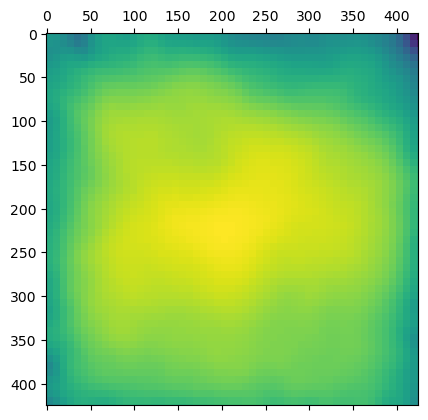

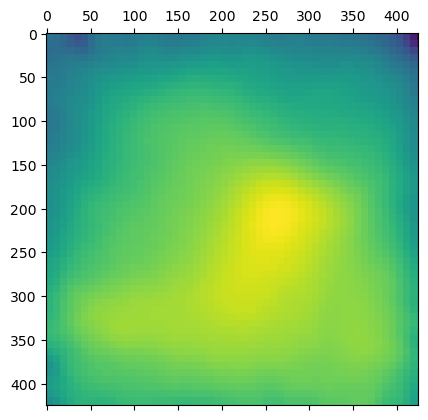

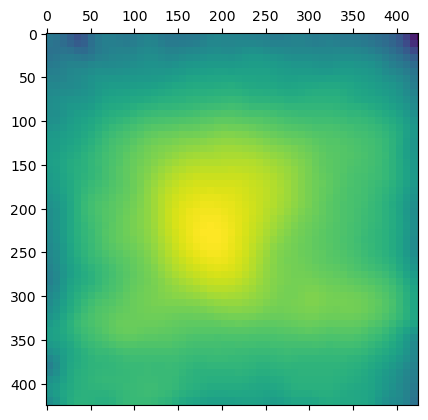

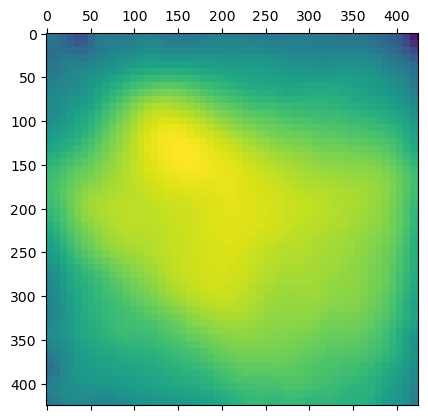

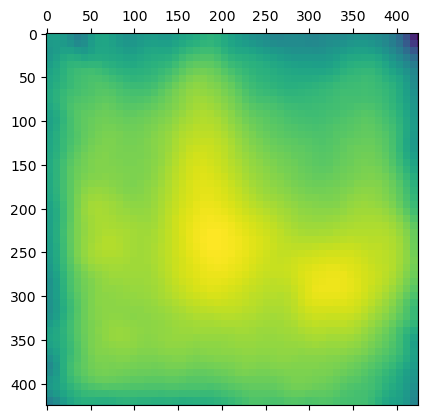

In [37]:
for idx in range(0,5): 
    sal_map = sal_maps_icf_all[idx]
    plt.matshow(sal_map)

In [44]:
ops.reset_default_graph()

In [45]:
with tf.Session() as sess:
    sal_maps_dg2_all = generate_maps_ICF_fix_sess(sess = sess, uniqe_img_indices =unique_img_indices, model = 'deepgaze2' , batch_size = 8)

2023-09-12 13:58:27.061765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:2f:00.0, compute capability: 7.5


'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


  0%|          | 0/1250 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  0%|          | 1/1250 [00:21<7:26:43, 21.46s/it]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  0%|          | 2/1250 [00:21<3:05:51,  8.94s/it]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  0%|          | 3/1250 [00:21<1:42:29,  4.93s/it]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  0%|          | 4/1250 [00:21<1:03:18,  3.05s/it]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  0%|          | 5/1250 [00:22<41:40,  2.01s/it]  

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  0%|          | 6/1250 [00:22<28:39,  1.38s/it]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|          | 7/1250 [00:22<20:27,  1.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|          | 8/1250 [00:22<15:03,  1.37it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|          | 9/1250 [00:22<11:27,  1.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|          | 10/1250 [00:22<09:01,  2.29it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|          | 11/1250 [00:23<07:16,  2.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|          | 12/1250 [00:23<06:07,  3.37it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|          | 13/1250 [00:23<05:20,  3.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|          | 14/1250 [00:23<04:47,  4.30it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|          | 15/1250 [00:23<04:22,  4.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|▏         | 16/1250 [00:23<04:06,  5.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|▏         | 17/1250 [00:24<03:55,  5.24it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  1%|▏         | 18/1250 [00:24<03:47,  5.42it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 19/1250 [00:24<03:39,  5.60it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 20/1250 [00:24<03:34,  5.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 21/1250 [00:24<03:31,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 22/1250 [00:24<03:27,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 23/1250 [00:25<03:27,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 24/1250 [00:25<03:27,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 25/1250 [00:25<03:26,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 26/1250 [00:25<03:27,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 27/1250 [00:25<03:26,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 28/1250 [00:25<03:24,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 29/1250 [00:26<03:24,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 30/1250 [00:26<03:23,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  2%|▏         | 31/1250 [00:26<03:22,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 32/1250 [00:26<03:23,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 33/1250 [00:26<03:22,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 34/1250 [00:26<03:23,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 35/1250 [00:27<03:22,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 36/1250 [00:27<03:22,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 37/1250 [00:27<03:23,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 38/1250 [00:27<03:22,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 39/1250 [00:27<03:22,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 40/1250 [00:27<03:20,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 41/1250 [00:28<03:22,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 42/1250 [00:28<03:21,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  3%|▎         | 43/1250 [00:28<03:21,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▎         | 44/1250 [00:28<03:19,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▎         | 45/1250 [00:28<03:19,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▎         | 46/1250 [00:28<03:20,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▍         | 47/1250 [00:29<03:20,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▍         | 48/1250 [00:29<03:19,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▍         | 49/1250 [00:29<03:20,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▍         | 50/1250 [00:29<03:20,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▍         | 51/1250 [00:29<03:20,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▍         | 52/1250 [00:29<03:20,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▍         | 53/1250 [00:30<03:19,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▍         | 54/1250 [00:30<03:19,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▍         | 55/1250 [00:30<03:20,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  4%|▍         | 56/1250 [00:30<03:20,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▍         | 57/1250 [00:30<03:21,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▍         | 58/1250 [00:30<03:17,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▍         | 59/1250 [00:31<03:17,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▍         | 60/1250 [00:31<03:19,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▍         | 61/1250 [00:31<03:28,  5.69it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▍         | 62/1250 [00:31<03:26,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▌         | 63/1250 [00:31<03:27,  5.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▌         | 64/1250 [00:32<03:31,  5.60it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▌         | 65/1250 [00:32<03:33,  5.56it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▌         | 66/1250 [00:32<03:29,  5.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▌         | 67/1250 [00:32<03:27,  5.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  5%|▌         | 68/1250 [00:32<03:24,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▌         | 69/1250 [00:32<03:23,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▌         | 70/1250 [00:33<03:21,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▌         | 71/1250 [00:33<03:21,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▌         | 72/1250 [00:33<03:21,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▌         | 73/1250 [00:33<03:21,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▌         | 74/1250 [00:33<03:21,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▌         | 75/1250 [00:33<03:20,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▌         | 76/1250 [00:34<03:18,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▌         | 77/1250 [00:34<03:18,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▌         | 78/1250 [00:34<03:18,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▋         | 79/1250 [00:34<03:17,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▋         | 80/1250 [00:34<03:17,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  6%|▋         | 81/1250 [00:34<03:16,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 82/1250 [00:35<03:17,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 83/1250 [00:35<03:18,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 84/1250 [00:35<03:17,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 85/1250 [00:35<03:18,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 86/1250 [00:35<03:17,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 87/1250 [00:35<03:16,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 88/1250 [00:36<03:15,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 89/1250 [00:36<03:13,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 90/1250 [00:36<03:17,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 91/1250 [00:36<03:24,  5.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 92/1250 [00:36<03:23,  5.69it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  7%|▋         | 93/1250 [00:37<03:19,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 94/1250 [00:37<03:24,  5.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 95/1250 [00:37<03:19,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 96/1250 [00:37<03:15,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 97/1250 [00:37<03:15,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 98/1250 [00:37<03:13,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 99/1250 [00:38<03:12,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 100/1250 [00:38<03:12,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 101/1250 [00:38<03:12,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 102/1250 [00:38<03:12,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 103/1250 [00:38<03:13,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 104/1250 [00:38<03:14,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 105/1250 [00:39<03:14,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  8%|▊         | 106/1250 [00:39<03:13,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▊         | 107/1250 [00:39<03:14,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▊         | 108/1250 [00:39<03:12,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▊         | 109/1250 [00:39<03:14,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▉         | 110/1250 [00:39<03:13,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▉         | 111/1250 [00:40<03:12,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▉         | 112/1250 [00:40<03:12,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▉         | 113/1250 [00:40<03:13,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▉         | 114/1250 [00:40<03:12,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▉         | 115/1250 [00:40<03:13,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▉         | 116/1250 [00:40<03:13,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▉         | 117/1250 [00:41<03:09,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


  9%|▉         | 118/1250 [00:41<03:11,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|▉         | 119/1250 [00:41<03:12,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|▉         | 120/1250 [00:41<03:11,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|▉         | 121/1250 [00:41<03:10,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|▉         | 122/1250 [00:41<03:10,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|▉         | 123/1250 [00:42<03:08,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|▉         | 124/1250 [00:42<03:09,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|█         | 125/1250 [00:42<03:08,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|█         | 126/1250 [00:42<03:08,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|█         | 127/1250 [00:42<03:09,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|█         | 128/1250 [00:42<03:10,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|█         | 129/1250 [00:43<03:09,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|█         | 130/1250 [00:43<03:10,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 10%|█         | 131/1250 [00:43<03:09,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█         | 132/1250 [00:43<03:09,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█         | 133/1250 [00:43<03:07,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█         | 134/1250 [00:43<03:07,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█         | 135/1250 [00:44<03:06,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█         | 136/1250 [00:44<03:06,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█         | 137/1250 [00:44<03:04,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█         | 138/1250 [00:44<03:03,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█         | 139/1250 [00:44<03:03,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█         | 140/1250 [00:44<03:03,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█▏        | 141/1250 [00:45<03:03,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█▏        | 142/1250 [00:45<03:03,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 11%|█▏        | 143/1250 [00:45<03:03,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 144/1250 [00:45<03:04,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 145/1250 [00:45<03:03,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 146/1250 [00:45<03:03,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 147/1250 [00:46<03:03,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 148/1250 [00:46<03:03,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 149/1250 [00:46<03:02,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 150/1250 [00:46<03:01,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 151/1250 [00:46<03:02,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 152/1250 [00:46<03:01,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 153/1250 [00:47<03:02,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 154/1250 [00:47<03:04,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 155/1250 [00:47<03:04,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 12%|█▏        | 156/1250 [00:47<03:03,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 157/1250 [00:47<03:03,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 158/1250 [00:47<03:05,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 159/1250 [00:48<03:05,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 160/1250 [00:48<03:06,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 161/1250 [00:48<03:06,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 162/1250 [00:48<03:05,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 163/1250 [00:48<03:03,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 164/1250 [00:48<03:03,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 165/1250 [00:49<03:03,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 166/1250 [00:49<03:02,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 167/1250 [00:49<03:03,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 13%|█▎        | 168/1250 [00:49<03:04,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▎        | 169/1250 [00:49<03:04,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▎        | 170/1250 [00:49<03:01,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▎        | 171/1250 [00:50<03:01,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▍        | 172/1250 [00:50<03:02,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▍        | 173/1250 [00:50<03:01,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▍        | 174/1250 [00:50<03:03,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▍        | 175/1250 [00:50<03:03,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▍        | 176/1250 [00:50<03:01,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▍        | 177/1250 [00:51<03:01,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▍        | 178/1250 [00:51<02:57,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▍        | 179/1250 [00:51<02:59,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▍        | 180/1250 [00:51<02:59,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 14%|█▍        | 181/1250 [00:51<02:59,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▍        | 182/1250 [00:51<03:00,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▍        | 183/1250 [00:52<02:56,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▍        | 184/1250 [00:52<02:56,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▍        | 185/1250 [00:52<02:56,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▍        | 186/1250 [00:52<02:57,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▍        | 187/1250 [00:52<02:58,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▌        | 188/1250 [00:53<02:59,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▌        | 189/1250 [00:53<03:00,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▌        | 190/1250 [00:53<02:58,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▌        | 191/1250 [00:53<02:58,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▌        | 192/1250 [00:53<02:57,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 15%|█▌        | 193/1250 [00:53<02:57,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▌        | 194/1250 [00:54<02:55,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▌        | 195/1250 [00:54<02:55,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▌        | 196/1250 [00:54<02:56,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▌        | 197/1250 [00:54<02:56,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▌        | 198/1250 [00:54<02:55,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▌        | 199/1250 [00:54<02:56,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▌        | 200/1250 [00:55<02:57,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▌        | 201/1250 [00:55<02:57,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▌        | 202/1250 [00:55<02:56,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▌        | 203/1250 [00:55<02:56,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▋        | 204/1250 [00:55<02:55,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▋        | 205/1250 [00:55<02:55,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 16%|█▋        | 206/1250 [00:56<02:55,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 207/1250 [00:56<02:56,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 208/1250 [00:56<02:57,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 209/1250 [00:56<02:57,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 210/1250 [00:56<02:56,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 211/1250 [00:56<02:56,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 212/1250 [00:57<02:54,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 213/1250 [00:57<02:53,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 214/1250 [00:57<02:52,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 215/1250 [00:57<02:53,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 216/1250 [00:57<02:54,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 217/1250 [00:57<02:55,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 17%|█▋        | 218/1250 [00:58<02:53,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 219/1250 [00:58<02:52,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 220/1250 [00:58<02:51,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 221/1250 [00:58<02:50,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 222/1250 [00:58<02:49,  6.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 223/1250 [00:58<02:48,  6.09it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 224/1250 [00:59<02:48,  6.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 225/1250 [00:59<02:49,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 226/1250 [00:59<02:49,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 227/1250 [00:59<02:49,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 228/1250 [00:59<02:50,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 229/1250 [00:59<02:52,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 230/1250 [01:00<02:50,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 18%|█▊        | 231/1250 [01:00<02:50,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▊        | 232/1250 [01:00<02:50,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▊        | 233/1250 [01:00<02:46,  6.09it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▊        | 234/1250 [01:00<02:48,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▉        | 235/1250 [01:00<02:47,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▉        | 236/1250 [01:01<02:48,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▉        | 237/1250 [01:01<02:46,  6.08it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▉        | 238/1250 [01:01<02:46,  6.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▉        | 239/1250 [01:01<02:48,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▉        | 240/1250 [01:01<02:45,  6.09it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▉        | 241/1250 [01:01<02:45,  6.11it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▉        | 242/1250 [01:02<02:51,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 19%|█▉        | 243/1250 [01:02<02:50,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|█▉        | 244/1250 [01:02<02:50,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|█▉        | 245/1250 [01:02<02:54,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|█▉        | 246/1250 [01:02<02:51,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|█▉        | 247/1250 [01:02<02:53,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|█▉        | 248/1250 [01:03<02:49,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|█▉        | 249/1250 [01:03<02:50,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|██        | 250/1250 [01:03<02:50,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|██        | 251/1250 [01:03<02:48,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|██        | 252/1250 [01:03<02:49,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|██        | 253/1250 [01:03<02:49,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|██        | 254/1250 [01:04<02:48,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|██        | 255/1250 [01:04<02:49,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 20%|██        | 256/1250 [01:04<02:49,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██        | 257/1250 [01:04<02:49,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██        | 258/1250 [01:04<02:50,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██        | 259/1250 [01:04<02:49,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██        | 260/1250 [01:05<02:48,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██        | 261/1250 [01:05<02:48,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██        | 262/1250 [01:05<02:50,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██        | 263/1250 [01:05<02:50,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██        | 264/1250 [01:05<02:48,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██        | 265/1250 [01:05<02:46,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██▏       | 266/1250 [01:06<02:49,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██▏       | 267/1250 [01:06<02:46,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 21%|██▏       | 268/1250 [01:06<02:46,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 269/1250 [01:06<02:49,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 270/1250 [01:06<02:50,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 271/1250 [01:06<02:48,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 272/1250 [01:07<02:44,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 273/1250 [01:07<02:42,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 274/1250 [01:07<02:41,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 275/1250 [01:07<02:42,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 276/1250 [01:07<02:41,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 277/1250 [01:07<02:40,  6.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 278/1250 [01:08<02:39,  6.09it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 279/1250 [01:08<02:38,  6.13it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 280/1250 [01:08<02:39,  6.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 22%|██▏       | 281/1250 [01:08<02:38,  6.10it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 282/1250 [01:08<02:39,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 283/1250 [01:08<02:39,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 284/1250 [01:09<02:37,  6.14it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 285/1250 [01:09<02:38,  6.10it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 286/1250 [01:09<02:38,  6.09it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 287/1250 [01:09<02:39,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 288/1250 [01:09<02:38,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 289/1250 [01:09<02:38,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 290/1250 [01:10<02:38,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 291/1250 [01:10<02:39,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 292/1250 [01:10<02:41,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 23%|██▎       | 293/1250 [01:10<02:39,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▎       | 294/1250 [01:10<02:38,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▎       | 295/1250 [01:10<02:39,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▎       | 296/1250 [01:11<02:39,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▍       | 297/1250 [01:11<02:40,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▍       | 298/1250 [01:11<02:41,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▍       | 299/1250 [01:11<02:40,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▍       | 300/1250 [01:11<02:41,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▍       | 301/1250 [01:11<02:41,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▍       | 302/1250 [01:12<02:39,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▍       | 303/1250 [01:12<02:40,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▍       | 304/1250 [01:12<02:39,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▍       | 305/1250 [01:12<02:39,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 24%|██▍       | 306/1250 [01:12<02:38,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▍       | 307/1250 [01:12<02:37,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▍       | 308/1250 [01:13<02:39,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▍       | 309/1250 [01:13<02:40,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▍       | 310/1250 [01:13<02:39,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▍       | 311/1250 [01:13<02:38,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▍       | 312/1250 [01:13<02:36,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▌       | 313/1250 [01:13<02:36,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▌       | 314/1250 [01:14<02:37,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▌       | 315/1250 [01:14<02:38,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▌       | 316/1250 [01:14<02:37,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▌       | 317/1250 [01:14<02:37,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 25%|██▌       | 318/1250 [01:14<02:38,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▌       | 319/1250 [01:15<02:39,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▌       | 320/1250 [01:15<02:38,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▌       | 321/1250 [01:15<02:37,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▌       | 322/1250 [01:15<02:37,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▌       | 323/1250 [01:15<02:38,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▌       | 324/1250 [01:15<02:36,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▌       | 325/1250 [01:16<02:35,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▌       | 326/1250 [01:16<02:35,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▌       | 327/1250 [01:16<02:34,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▌       | 328/1250 [01:16<02:33,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▋       | 329/1250 [01:16<02:34,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▋       | 330/1250 [01:16<02:34,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 26%|██▋       | 331/1250 [01:17<02:34,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 332/1250 [01:17<02:35,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 333/1250 [01:17<02:35,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 334/1250 [01:17<02:34,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 335/1250 [01:17<02:34,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 336/1250 [01:17<02:33,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 337/1250 [01:18<02:33,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 338/1250 [01:18<02:32,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 339/1250 [01:18<02:32,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 340/1250 [01:18<02:31,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 341/1250 [01:18<02:32,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 342/1250 [01:18<02:33,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 27%|██▋       | 343/1250 [01:19<02:30,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 344/1250 [01:19<02:30,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 345/1250 [01:19<02:31,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 346/1250 [01:19<02:31,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 347/1250 [01:19<02:30,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 348/1250 [01:19<02:30,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 349/1250 [01:20<02:28,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 350/1250 [01:20<02:28,  6.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 351/1250 [01:20<02:28,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 352/1250 [01:20<02:27,  6.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 353/1250 [01:20<02:28,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 354/1250 [01:20<02:28,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 355/1250 [01:21<02:29,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 28%|██▊       | 356/1250 [01:21<02:27,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▊       | 357/1250 [01:21<02:27,  6.07it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▊       | 358/1250 [01:21<02:27,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▊       | 359/1250 [01:21<02:28,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▉       | 360/1250 [01:21<02:30,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▉       | 361/1250 [01:22<02:29,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▉       | 362/1250 [01:22<02:28,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▉       | 363/1250 [01:22<02:30,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▉       | 364/1250 [01:22<02:30,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▉       | 365/1250 [01:22<02:27,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▉       | 366/1250 [01:22<02:27,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▉       | 367/1250 [01:23<02:28,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 29%|██▉       | 368/1250 [01:23<02:27,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|██▉       | 369/1250 [01:23<02:27,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|██▉       | 370/1250 [01:23<02:29,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|██▉       | 371/1250 [01:23<02:29,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|██▉       | 372/1250 [01:23<02:29,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|██▉       | 373/1250 [01:24<02:28,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|██▉       | 374/1250 [01:24<02:28,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|███       | 375/1250 [01:24<02:28,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|███       | 376/1250 [01:24<02:28,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|███       | 377/1250 [01:24<02:29,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|███       | 378/1250 [01:24<02:29,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|███       | 379/1250 [01:25<02:29,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|███       | 380/1250 [01:25<02:29,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 30%|███       | 381/1250 [01:25<02:29,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███       | 382/1250 [01:25<02:29,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███       | 383/1250 [01:25<02:28,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███       | 384/1250 [01:25<02:28,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███       | 385/1250 [01:26<02:27,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███       | 386/1250 [01:26<02:26,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███       | 387/1250 [01:26<02:25,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███       | 388/1250 [01:26<02:25,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███       | 389/1250 [01:26<02:26,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███       | 390/1250 [01:26<02:25,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███▏      | 391/1250 [01:27<02:27,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███▏      | 392/1250 [01:27<02:27,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 31%|███▏      | 393/1250 [01:27<02:27,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 394/1250 [01:27<02:27,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 395/1250 [01:27<02:26,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 396/1250 [01:27<02:24,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 397/1250 [01:28<02:23,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 398/1250 [01:28<02:23,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 399/1250 [01:28<02:23,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 400/1250 [01:28<02:22,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 401/1250 [01:28<02:22,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 402/1250 [01:29<02:23,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 403/1250 [01:29<02:22,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 404/1250 [01:29<02:22,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 405/1250 [01:29<02:22,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 32%|███▏      | 406/1250 [01:29<02:21,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 407/1250 [01:29<02:21,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 408/1250 [01:30<02:20,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 409/1250 [01:30<02:19,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 410/1250 [01:30<02:19,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 411/1250 [01:30<02:20,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 412/1250 [01:30<02:20,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 413/1250 [01:30<02:20,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 414/1250 [01:31<02:20,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 415/1250 [01:31<02:19,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 416/1250 [01:31<02:19,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 417/1250 [01:31<02:19,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 33%|███▎      | 418/1250 [01:31<02:19,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▎      | 419/1250 [01:31<02:18,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▎      | 420/1250 [01:32<02:18,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▎      | 421/1250 [01:32<02:18,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▍      | 422/1250 [01:32<02:24,  5.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▍      | 423/1250 [01:32<02:28,  5.57it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▍      | 424/1250 [01:32<02:25,  5.68it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▍      | 425/1250 [01:32<02:26,  5.63it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▍      | 426/1250 [01:33<02:25,  5.68it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▍      | 427/1250 [01:33<02:23,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▍      | 428/1250 [01:33<02:21,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▍      | 429/1250 [01:33<02:19,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▍      | 430/1250 [01:33<02:18,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 34%|███▍      | 431/1250 [01:33<02:18,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▍      | 432/1250 [01:34<02:17,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▍      | 433/1250 [01:34<02:17,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▍      | 434/1250 [01:34<02:18,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▍      | 435/1250 [01:34<02:17,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▍      | 436/1250 [01:34<02:17,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▍      | 437/1250 [01:34<02:16,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▌      | 438/1250 [01:35<02:16,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▌      | 439/1250 [01:35<02:15,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▌      | 440/1250 [01:35<02:14,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▌      | 441/1250 [01:35<02:14,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▌      | 442/1250 [01:35<02:15,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 35%|███▌      | 443/1250 [01:35<02:16,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▌      | 444/1250 [01:36<02:16,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▌      | 445/1250 [01:36<02:17,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▌      | 446/1250 [01:36<02:15,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▌      | 447/1250 [01:36<02:15,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▌      | 448/1250 [01:36<02:15,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▌      | 449/1250 [01:36<02:14,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▌      | 450/1250 [01:37<02:24,  5.54it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▌      | 451/1250 [01:37<02:20,  5.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▌      | 452/1250 [01:37<02:18,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▌      | 453/1250 [01:37<02:22,  5.61it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▋      | 454/1250 [01:37<02:18,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▋      | 455/1250 [01:38<02:17,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 36%|███▋      | 456/1250 [01:38<02:15,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 457/1250 [01:38<02:15,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 458/1250 [01:38<02:15,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 459/1250 [01:38<02:14,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 460/1250 [01:38<02:14,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 461/1250 [01:39<02:14,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 462/1250 [01:39<02:13,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 463/1250 [01:39<02:14,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 464/1250 [01:39<02:13,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 465/1250 [01:39<02:14,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 466/1250 [01:39<02:13,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 467/1250 [01:40<02:12,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 37%|███▋      | 468/1250 [01:40<02:12,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 469/1250 [01:40<02:11,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 470/1250 [01:40<02:11,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 471/1250 [01:40<02:10,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 472/1250 [01:40<02:11,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 473/1250 [01:41<02:08,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 474/1250 [01:41<02:08,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 475/1250 [01:41<02:08,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 476/1250 [01:41<02:09,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 477/1250 [01:41<02:09,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 478/1250 [01:41<02:09,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 479/1250 [01:42<02:09,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 480/1250 [01:42<02:08,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 38%|███▊      | 481/1250 [01:42<02:09,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▊      | 482/1250 [01:42<02:09,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▊      | 483/1250 [01:42<02:08,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▊      | 484/1250 [01:42<02:08,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▉      | 485/1250 [01:43<02:08,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▉      | 486/1250 [01:43<02:08,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▉      | 487/1250 [01:43<02:07,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▉      | 488/1250 [01:43<02:08,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▉      | 489/1250 [01:43<02:08,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▉      | 490/1250 [01:43<02:07,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▉      | 491/1250 [01:44<02:07,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▉      | 492/1250 [01:44<02:07,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 39%|███▉      | 493/1250 [01:44<02:08,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|███▉      | 494/1250 [01:44<02:07,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|███▉      | 495/1250 [01:44<02:09,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|███▉      | 496/1250 [01:44<02:07,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|███▉      | 497/1250 [01:45<02:07,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|███▉      | 498/1250 [01:45<02:05,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|███▉      | 499/1250 [01:45<02:05,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|████      | 500/1250 [01:45<02:05,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|████      | 501/1250 [01:45<02:05,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|████      | 502/1250 [01:45<02:06,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|████      | 503/1250 [01:46<02:03,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|████      | 504/1250 [01:46<02:04,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|████      | 505/1250 [01:46<02:03,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 40%|████      | 506/1250 [01:46<02:03,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████      | 507/1250 [01:46<02:04,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████      | 508/1250 [01:46<02:03,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████      | 509/1250 [01:47<02:04,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████      | 510/1250 [01:47<02:04,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████      | 511/1250 [01:47<02:05,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████      | 512/1250 [01:47<02:04,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████      | 513/1250 [01:47<02:04,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████      | 514/1250 [01:47<02:02,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████      | 515/1250 [01:48<02:03,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████▏     | 516/1250 [01:48<02:01,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████▏     | 517/1250 [01:48<02:01,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 41%|████▏     | 518/1250 [01:48<02:01,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 519/1250 [01:48<02:01,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 520/1250 [01:48<02:01,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 521/1250 [01:49<02:02,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 522/1250 [01:49<02:01,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 523/1250 [01:49<02:00,  6.04it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 524/1250 [01:49<01:59,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 525/1250 [01:49<01:59,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 526/1250 [01:49<01:59,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 527/1250 [01:50<01:58,  6.10it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 528/1250 [01:50<01:59,  6.06it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 529/1250 [01:50<02:00,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 530/1250 [01:50<02:00,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 42%|████▏     | 531/1250 [01:50<01:59,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 532/1250 [01:50<01:59,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 533/1250 [01:51<01:58,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 534/1250 [01:51<01:59,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 535/1250 [01:51<02:00,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 536/1250 [01:51<01:59,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 537/1250 [01:51<01:59,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 538/1250 [01:51<02:00,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 539/1250 [01:52<02:00,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 540/1250 [01:52<02:00,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 541/1250 [01:52<01:58,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 542/1250 [01:52<01:59,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 43%|████▎     | 543/1250 [01:52<01:59,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▎     | 544/1250 [01:52<01:59,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▎     | 545/1250 [01:53<01:59,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▎     | 546/1250 [01:53<02:00,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▍     | 547/1250 [01:53<01:59,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▍     | 548/1250 [01:53<01:59,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▍     | 549/1250 [01:53<01:58,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▍     | 550/1250 [01:53<01:58,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▍     | 551/1250 [01:54<01:57,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▍     | 552/1250 [01:54<01:57,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▍     | 553/1250 [01:54<01:58,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▍     | 554/1250 [01:54<01:57,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▍     | 555/1250 [01:54<01:57,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 44%|████▍     | 556/1250 [01:54<01:56,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▍     | 557/1250 [01:55<01:56,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▍     | 558/1250 [01:55<01:55,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▍     | 559/1250 [01:55<01:55,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▍     | 560/1250 [01:55<01:56,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▍     | 561/1250 [01:55<01:56,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▍     | 562/1250 [01:55<01:55,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▌     | 563/1250 [01:56<01:55,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▌     | 564/1250 [01:56<01:55,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▌     | 565/1250 [01:56<01:55,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▌     | 566/1250 [01:56<01:54,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▌     | 567/1250 [01:56<01:54,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 45%|████▌     | 568/1250 [01:56<01:54,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▌     | 569/1250 [01:57<01:54,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▌     | 570/1250 [01:57<01:55,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▌     | 571/1250 [01:57<01:54,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▌     | 572/1250 [01:57<01:54,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▌     | 573/1250 [01:57<01:54,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▌     | 574/1250 [01:58<01:53,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▌     | 575/1250 [01:58<01:53,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▌     | 576/1250 [01:58<01:52,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▌     | 577/1250 [01:58<01:52,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▌     | 578/1250 [01:58<01:53,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▋     | 579/1250 [01:58<01:52,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▋     | 580/1250 [01:59<01:52,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 46%|████▋     | 581/1250 [01:59<01:52,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 582/1250 [01:59<01:52,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 583/1250 [01:59<01:51,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 584/1250 [01:59<01:52,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 585/1250 [01:59<01:51,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 586/1250 [02:00<01:50,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 587/1250 [02:00<01:50,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 588/1250 [02:00<01:50,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 589/1250 [02:00<01:50,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 590/1250 [02:00<01:51,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 591/1250 [02:00<01:51,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 592/1250 [02:01<01:51,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 47%|████▋     | 593/1250 [02:01<01:51,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 594/1250 [02:01<01:50,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 595/1250 [02:01<01:50,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 596/1250 [02:01<01:49,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 597/1250 [02:01<01:49,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 598/1250 [02:02<01:50,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 599/1250 [02:02<01:50,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 600/1250 [02:02<01:50,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 601/1250 [02:02<01:50,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 602/1250 [02:02<01:48,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 603/1250 [02:02<01:47,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 604/1250 [02:03<01:48,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 605/1250 [02:03<01:47,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 48%|████▊     | 606/1250 [02:03<01:48,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▊     | 607/1250 [02:03<01:48,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▊     | 608/1250 [02:03<01:48,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▊     | 609/1250 [02:03<01:48,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▉     | 610/1250 [02:04<01:47,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▉     | 611/1250 [02:04<01:50,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▉     | 612/1250 [02:04<01:53,  5.62it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▉     | 613/1250 [02:04<01:51,  5.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▉     | 614/1250 [02:04<01:49,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▉     | 615/1250 [02:04<01:50,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▉     | 616/1250 [02:05<01:49,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▉     | 617/1250 [02:05<01:49,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 49%|████▉     | 618/1250 [02:05<01:48,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|████▉     | 619/1250 [02:05<01:48,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|████▉     | 620/1250 [02:05<01:48,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|████▉     | 621/1250 [02:05<01:48,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|████▉     | 622/1250 [02:06<01:48,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|████▉     | 623/1250 [02:06<01:47,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|████▉     | 624/1250 [02:06<01:47,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|█████     | 625/1250 [02:06<01:46,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|█████     | 626/1250 [02:06<01:46,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|█████     | 627/1250 [02:07<01:46,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|█████     | 628/1250 [02:07<01:46,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|█████     | 629/1250 [02:07<01:46,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|█████     | 630/1250 [02:07<01:46,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 50%|█████     | 631/1250 [02:07<01:46,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████     | 632/1250 [02:07<01:47,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████     | 633/1250 [02:08<01:47,  5.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████     | 634/1250 [02:08<01:48,  5.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████     | 635/1250 [02:08<01:47,  5.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████     | 636/1250 [02:08<01:46,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████     | 637/1250 [02:08<01:49,  5.58it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████     | 638/1250 [02:08<01:48,  5.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████     | 639/1250 [02:09<01:46,  5.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████     | 640/1250 [02:09<01:50,  5.53it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████▏    | 641/1250 [02:09<01:49,  5.59it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████▏    | 642/1250 [02:09<01:47,  5.64it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 51%|█████▏    | 643/1250 [02:09<01:46,  5.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 644/1250 [02:09<01:45,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 645/1250 [02:10<01:43,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 646/1250 [02:10<01:42,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 647/1250 [02:10<01:43,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 648/1250 [02:10<01:43,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 649/1250 [02:10<01:43,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 650/1250 [02:11<01:43,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 651/1250 [02:11<01:44,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 652/1250 [02:11<01:43,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 653/1250 [02:11<01:43,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 654/1250 [02:11<01:44,  5.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 655/1250 [02:11<01:44,  5.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 52%|█████▏    | 656/1250 [02:12<01:43,  5.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 657/1250 [02:12<01:43,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 658/1250 [02:12<01:42,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 659/1250 [02:12<01:41,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 660/1250 [02:12<01:41,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 661/1250 [02:12<01:41,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 662/1250 [02:13<01:41,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 663/1250 [02:13<01:40,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 664/1250 [02:13<01:39,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 665/1250 [02:13<01:39,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 666/1250 [02:13<01:39,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 667/1250 [02:13<01:39,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 53%|█████▎    | 668/1250 [02:14<01:38,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▎    | 669/1250 [02:14<01:38,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▎    | 670/1250 [02:14<01:38,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▎    | 671/1250 [02:14<01:37,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▍    | 672/1250 [02:14<01:37,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▍    | 673/1250 [02:14<01:36,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▍    | 674/1250 [02:15<01:35,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▍    | 675/1250 [02:15<01:36,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▍    | 676/1250 [02:15<01:35,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▍    | 677/1250 [02:15<01:36,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▍    | 678/1250 [02:15<01:36,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▍    | 679/1250 [02:15<01:36,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▍    | 680/1250 [02:16<01:36,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 54%|█████▍    | 681/1250 [02:16<01:34,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▍    | 682/1250 [02:16<01:34,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▍    | 683/1250 [02:16<01:34,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▍    | 684/1250 [02:16<01:34,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▍    | 685/1250 [02:16<01:34,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▍    | 686/1250 [02:17<01:34,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▍    | 687/1250 [02:17<01:35,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▌    | 688/1250 [02:17<01:35,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▌    | 689/1250 [02:17<01:35,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▌    | 690/1250 [02:17<01:36,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▌    | 691/1250 [02:17<01:35,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▌    | 692/1250 [02:18<01:35,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 55%|█████▌    | 693/1250 [02:18<01:35,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▌    | 694/1250 [02:18<01:35,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▌    | 695/1250 [02:18<01:35,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▌    | 696/1250 [02:18<01:34,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▌    | 697/1250 [02:19<01:33,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▌    | 698/1250 [02:19<01:32,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▌    | 699/1250 [02:19<01:31,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▌    | 700/1250 [02:19<01:31,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▌    | 701/1250 [02:19<01:32,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▌    | 702/1250 [02:19<01:32,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▌    | 703/1250 [02:20<01:31,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▋    | 704/1250 [02:20<01:31,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▋    | 705/1250 [02:20<01:31,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 56%|█████▋    | 706/1250 [02:20<01:31,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 707/1250 [02:20<01:31,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 708/1250 [02:20<01:30,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 709/1250 [02:21<01:31,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 710/1250 [02:21<01:30,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 711/1250 [02:21<01:30,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 712/1250 [02:21<01:29,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 713/1250 [02:21<01:29,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 714/1250 [02:21<01:29,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 715/1250 [02:22<01:29,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 716/1250 [02:22<01:28,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 717/1250 [02:22<01:29,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 57%|█████▋    | 718/1250 [02:22<01:28,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 719/1250 [02:22<01:29,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 720/1250 [02:22<01:29,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 721/1250 [02:23<01:29,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 722/1250 [02:23<01:28,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 723/1250 [02:23<01:28,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 724/1250 [02:23<01:29,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 725/1250 [02:23<01:29,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 726/1250 [02:23<01:28,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 727/1250 [02:24<01:28,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 728/1250 [02:24<01:28,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 729/1250 [02:24<01:29,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 730/1250 [02:24<01:28,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 58%|█████▊    | 731/1250 [02:24<01:28,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▊    | 732/1250 [02:24<01:28,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▊    | 733/1250 [02:25<01:29,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▊    | 734/1250 [02:25<01:29,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▉    | 735/1250 [02:25<01:29,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▉    | 736/1250 [02:25<01:29,  5.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▉    | 737/1250 [02:25<01:29,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▉    | 738/1250 [02:25<01:28,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▉    | 739/1250 [02:26<01:26,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▉    | 740/1250 [02:26<01:25,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▉    | 741/1250 [02:26<01:25,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▉    | 742/1250 [02:26<01:25,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 59%|█████▉    | 743/1250 [02:26<01:25,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|█████▉    | 744/1250 [02:26<01:25,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|█████▉    | 745/1250 [02:27<01:25,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|█████▉    | 746/1250 [02:27<01:23,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|█████▉    | 747/1250 [02:27<01:23,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|█████▉    | 748/1250 [02:27<01:24,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|█████▉    | 749/1250 [02:27<01:24,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|██████    | 750/1250 [02:27<01:24,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|██████    | 751/1250 [02:28<01:24,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|██████    | 752/1250 [02:28<01:24,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|██████    | 753/1250 [02:28<01:24,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|██████    | 754/1250 [02:28<01:24,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|██████    | 755/1250 [02:28<01:24,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 60%|██████    | 756/1250 [02:28<01:24,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████    | 757/1250 [02:29<01:23,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████    | 758/1250 [02:29<01:23,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████    | 759/1250 [02:29<01:24,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████    | 760/1250 [02:29<01:24,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████    | 761/1250 [02:29<01:24,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████    | 762/1250 [02:30<01:23,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████    | 763/1250 [02:30<01:23,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████    | 764/1250 [02:30<01:23,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████    | 765/1250 [02:30<01:23,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████▏   | 766/1250 [02:30<01:23,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████▏   | 767/1250 [02:30<01:23,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 61%|██████▏   | 768/1250 [02:31<01:23,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 769/1250 [02:31<01:23,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 770/1250 [02:31<01:23,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 771/1250 [02:31<01:23,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 772/1250 [02:31<01:22,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 773/1250 [02:31<01:22,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 774/1250 [02:32<01:21,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 775/1250 [02:32<01:21,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 776/1250 [02:32<01:21,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 777/1250 [02:32<01:21,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 778/1250 [02:32<01:22,  5.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 779/1250 [02:32<01:22,  5.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 780/1250 [02:33<01:21,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 62%|██████▏   | 781/1250 [02:33<01:20,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 782/1250 [02:33<01:20,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 783/1250 [02:33<01:19,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 784/1250 [02:33<01:19,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 785/1250 [02:33<01:18,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 786/1250 [02:34<01:18,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 787/1250 [02:34<01:18,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 788/1250 [02:34<01:18,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 789/1250 [02:34<01:17,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 790/1250 [02:34<01:18,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 791/1250 [02:34<01:17,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 792/1250 [02:35<01:17,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 63%|██████▎   | 793/1250 [02:35<01:17,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▎   | 794/1250 [02:35<01:17,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▎   | 795/1250 [02:35<01:17,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▎   | 796/1250 [02:35<01:15,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▍   | 797/1250 [02:35<01:14,  6.05it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▍   | 798/1250 [02:36<01:17,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▍   | 799/1250 [02:36<01:16,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▍   | 800/1250 [02:36<01:16,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▍   | 801/1250 [02:36<01:16,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▍   | 802/1250 [02:36<01:17,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▍   | 803/1250 [02:37<01:16,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▍   | 804/1250 [02:37<01:15,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▍   | 805/1250 [02:37<01:15,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 64%|██████▍   | 806/1250 [02:37<01:14,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▍   | 807/1250 [02:37<01:14,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▍   | 808/1250 [02:37<01:14,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▍   | 809/1250 [02:38<01:14,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▍   | 810/1250 [02:38<01:14,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▍   | 811/1250 [02:38<01:14,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▍   | 812/1250 [02:38<01:15,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▌   | 813/1250 [02:38<01:15,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▌   | 814/1250 [02:38<01:15,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▌   | 815/1250 [02:39<01:15,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▌   | 816/1250 [02:39<01:14,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▌   | 817/1250 [02:39<01:14,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 65%|██████▌   | 818/1250 [02:39<01:14,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▌   | 819/1250 [02:39<01:14,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▌   | 820/1250 [02:39<01:14,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▌   | 821/1250 [02:40<01:14,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▌   | 822/1250 [02:40<01:13,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▌   | 823/1250 [02:40<01:15,  5.63it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▌   | 824/1250 [02:40<01:14,  5.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▌   | 825/1250 [02:40<01:12,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▌   | 826/1250 [02:40<01:11,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▌   | 827/1250 [02:41<01:11,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▌   | 828/1250 [02:41<01:12,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▋   | 829/1250 [02:41<01:12,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▋   | 830/1250 [02:41<01:14,  5.60it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 66%|██████▋   | 831/1250 [02:41<01:13,  5.68it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 832/1250 [02:42<01:13,  5.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 833/1250 [02:42<01:12,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 834/1250 [02:42<01:12,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 835/1250 [02:42<01:11,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 836/1250 [02:42<01:11,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 837/1250 [02:42<01:11,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 838/1250 [02:43<01:10,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 839/1250 [02:43<01:10,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 840/1250 [02:43<01:09,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 841/1250 [02:43<01:08,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 842/1250 [02:43<01:08,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 67%|██████▋   | 843/1250 [02:43<01:08,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 844/1250 [02:44<01:07,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 845/1250 [02:44<01:07,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 846/1250 [02:44<01:07,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 847/1250 [02:44<01:07,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 848/1250 [02:44<01:07,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 849/1250 [02:44<01:07,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 850/1250 [02:45<01:07,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 851/1250 [02:45<01:07,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 852/1250 [02:45<01:07,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 853/1250 [02:45<01:08,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 854/1250 [02:45<01:09,  5.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 855/1250 [02:45<01:08,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 68%|██████▊   | 856/1250 [02:46<01:07,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▊   | 857/1250 [02:46<01:07,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▊   | 858/1250 [02:46<01:06,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▊   | 859/1250 [02:46<01:06,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▉   | 860/1250 [02:46<01:06,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▉   | 861/1250 [02:46<01:06,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▉   | 862/1250 [02:47<01:06,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▉   | 863/1250 [02:47<01:05,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▉   | 864/1250 [02:47<01:05,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▉   | 865/1250 [02:47<01:05,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▉   | 866/1250 [02:47<01:05,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▉   | 867/1250 [02:47<01:04,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 69%|██████▉   | 868/1250 [02:48<01:05,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|██████▉   | 869/1250 [02:48<01:05,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|██████▉   | 870/1250 [02:48<01:04,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|██████▉   | 871/1250 [02:48<01:04,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|██████▉   | 872/1250 [02:48<01:04,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|██████▉   | 873/1250 [02:48<01:04,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|██████▉   | 874/1250 [02:49<01:04,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|███████   | 875/1250 [02:49<01:04,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|███████   | 876/1250 [02:49<01:03,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|███████   | 877/1250 [02:49<01:03,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|███████   | 878/1250 [02:49<01:03,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|███████   | 879/1250 [02:50<01:02,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|███████   | 880/1250 [02:50<01:02,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 70%|███████   | 881/1250 [02:50<01:02,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████   | 882/1250 [02:50<01:01,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████   | 883/1250 [02:50<01:01,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████   | 884/1250 [02:50<01:01,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████   | 885/1250 [02:51<01:01,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████   | 886/1250 [02:51<01:01,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████   | 887/1250 [02:51<01:00,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████   | 888/1250 [02:51<01:00,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████   | 889/1250 [02:51<01:00,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████   | 890/1250 [02:51<01:00,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████▏  | 891/1250 [02:52<01:00,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████▏  | 892/1250 [02:52<01:00,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 71%|███████▏  | 893/1250 [02:52<01:00,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 894/1250 [02:52<01:00,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 895/1250 [02:52<01:00,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 896/1250 [02:52<01:00,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 897/1250 [02:53<01:00,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 898/1250 [02:53<00:59,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 899/1250 [02:53<01:00,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 900/1250 [02:53<01:00,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 901/1250 [02:53<00:59,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 902/1250 [02:53<00:59,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 903/1250 [02:54<00:59,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 904/1250 [02:54<00:59,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 905/1250 [02:54<00:59,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 72%|███████▏  | 906/1250 [02:54<00:59,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 907/1250 [02:54<00:59,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 908/1250 [02:54<00:58,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 909/1250 [02:55<00:58,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 910/1250 [02:55<00:58,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 911/1250 [02:55<00:57,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 912/1250 [02:55<00:57,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 913/1250 [02:55<00:57,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 914/1250 [02:55<00:57,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 915/1250 [02:56<00:57,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 916/1250 [02:56<00:57,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 917/1250 [02:56<00:56,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 73%|███████▎  | 918/1250 [02:56<00:56,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▎  | 919/1250 [02:56<00:55,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▎  | 920/1250 [02:56<00:54,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▎  | 921/1250 [02:57<00:54,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▍  | 922/1250 [02:57<00:54,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▍  | 923/1250 [02:57<00:54,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▍  | 924/1250 [02:57<00:53,  6.09it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▍  | 925/1250 [02:57<00:53,  6.02it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▍  | 926/1250 [02:57<00:53,  6.03it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▍  | 927/1250 [02:58<00:53,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▍  | 928/1250 [02:58<00:54,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▍  | 929/1250 [02:58<00:53,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▍  | 930/1250 [02:58<00:53,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 74%|███████▍  | 931/1250 [02:58<00:53,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▍  | 932/1250 [02:58<00:53,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▍  | 933/1250 [02:59<00:52,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▍  | 934/1250 [02:59<00:52,  5.99it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▍  | 935/1250 [02:59<00:53,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▍  | 936/1250 [02:59<00:52,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▍  | 937/1250 [02:59<00:52,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▌  | 938/1250 [02:59<00:52,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▌  | 939/1250 [03:00<00:52,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▌  | 940/1250 [03:00<00:52,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▌  | 941/1250 [03:00<00:51,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▌  | 942/1250 [03:00<00:51,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 75%|███████▌  | 943/1250 [03:00<00:51,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▌  | 944/1250 [03:01<00:51,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▌  | 945/1250 [03:01<00:52,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▌  | 946/1250 [03:01<00:51,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▌  | 947/1250 [03:01<00:51,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▌  | 948/1250 [03:01<00:50,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▌  | 949/1250 [03:01<00:50,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▌  | 950/1250 [03:02<00:50,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▌  | 951/1250 [03:02<00:50,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▌  | 952/1250 [03:02<00:50,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▌  | 953/1250 [03:02<00:50,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▋  | 954/1250 [03:02<00:50,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▋  | 955/1250 [03:02<00:49,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 76%|███████▋  | 956/1250 [03:03<00:50,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 957/1250 [03:03<00:50,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 958/1250 [03:03<00:50,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 959/1250 [03:03<00:49,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 960/1250 [03:03<00:49,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 961/1250 [03:03<00:49,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 962/1250 [03:04<00:48,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 963/1250 [03:04<00:49,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 964/1250 [03:04<00:49,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 965/1250 [03:04<00:48,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 966/1250 [03:04<00:48,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 967/1250 [03:04<00:48,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 77%|███████▋  | 968/1250 [03:05<00:48,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 969/1250 [03:05<00:47,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 970/1250 [03:05<00:47,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 971/1250 [03:05<00:47,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 972/1250 [03:05<00:47,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 973/1250 [03:05<00:46,  6.00it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 974/1250 [03:06<00:45,  6.01it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 975/1250 [03:06<00:45,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 976/1250 [03:06<00:46,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 977/1250 [03:06<00:46,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 978/1250 [03:06<00:46,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 979/1250 [03:06<00:46,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 980/1250 [03:07<00:46,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 78%|███████▊  | 981/1250 [03:07<00:45,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▊  | 982/1250 [03:07<00:45,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▊  | 983/1250 [03:07<00:45,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▊  | 984/1250 [03:07<00:46,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▉  | 985/1250 [03:07<00:45,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▉  | 986/1250 [03:08<00:44,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▉  | 987/1250 [03:08<00:44,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▉  | 988/1250 [03:08<00:44,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▉  | 989/1250 [03:08<00:44,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▉  | 990/1250 [03:08<00:45,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▉  | 991/1250 [03:09<00:46,  5.53it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▉  | 992/1250 [03:09<00:47,  5.47it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 79%|███████▉  | 993/1250 [03:09<00:45,  5.59it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|███████▉  | 994/1250 [03:09<00:45,  5.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|███████▉  | 995/1250 [03:09<00:45,  5.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|███████▉  | 996/1250 [03:09<00:44,  5.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|███████▉  | 997/1250 [03:10<00:44,  5.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|███████▉  | 998/1250 [03:10<00:43,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|███████▉  | 999/1250 [03:10<00:43,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|████████  | 1000/1250 [03:10<00:42,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|████████  | 1001/1250 [03:10<00:42,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|████████  | 1002/1250 [03:10<00:41,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|████████  | 1003/1250 [03:11<00:41,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|████████  | 1004/1250 [03:11<00:41,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|████████  | 1005/1250 [03:11<00:40,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 80%|████████  | 1006/1250 [03:11<00:40,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████  | 1007/1250 [03:11<00:40,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████  | 1008/1250 [03:11<00:40,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████  | 1009/1250 [03:12<00:40,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████  | 1010/1250 [03:12<00:40,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████  | 1011/1250 [03:12<00:41,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████  | 1012/1250 [03:12<00:40,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████  | 1013/1250 [03:12<00:41,  5.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████  | 1014/1250 [03:12<00:41,  5.71it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████  | 1015/1250 [03:13<00:40,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████▏ | 1016/1250 [03:13<00:40,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████▏ | 1017/1250 [03:13<00:40,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 81%|████████▏ | 1018/1250 [03:13<00:39,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1019/1250 [03:13<00:40,  5.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1020/1250 [03:14<00:39,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1021/1250 [03:14<00:39,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1022/1250 [03:14<00:39,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1023/1250 [03:14<00:39,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1024/1250 [03:14<00:38,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1025/1250 [03:14<00:38,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1026/1250 [03:15<00:38,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1027/1250 [03:15<00:38,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1028/1250 [03:15<00:38,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1029/1250 [03:15<00:38,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1030/1250 [03:15<00:37,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 82%|████████▏ | 1031/1250 [03:15<00:37,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1032/1250 [03:16<00:37,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1033/1250 [03:16<00:37,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1034/1250 [03:16<00:36,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1035/1250 [03:16<00:36,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1036/1250 [03:16<00:36,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1037/1250 [03:16<00:35,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1038/1250 [03:17<00:35,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1039/1250 [03:17<00:35,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1040/1250 [03:17<00:35,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1041/1250 [03:17<00:35,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1042/1250 [03:17<00:35,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 83%|████████▎ | 1043/1250 [03:17<00:34,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▎ | 1044/1250 [03:18<00:34,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▎ | 1045/1250 [03:18<00:34,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▎ | 1046/1250 [03:18<00:34,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▍ | 1047/1250 [03:18<00:34,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▍ | 1048/1250 [03:18<00:34,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▍ | 1049/1250 [03:18<00:33,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▍ | 1050/1250 [03:19<00:33,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▍ | 1051/1250 [03:19<00:33,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▍ | 1052/1250 [03:19<00:33,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▍ | 1053/1250 [03:19<00:33,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▍ | 1054/1250 [03:19<00:33,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▍ | 1055/1250 [03:19<00:33,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 84%|████████▍ | 1056/1250 [03:20<00:33,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▍ | 1057/1250 [03:20<00:33,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▍ | 1058/1250 [03:20<00:33,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▍ | 1059/1250 [03:20<00:33,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▍ | 1060/1250 [03:20<00:33,  5.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▍ | 1061/1250 [03:21<00:32,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▍ | 1062/1250 [03:21<00:32,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▌ | 1063/1250 [03:21<00:32,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▌ | 1064/1250 [03:21<00:32,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▌ | 1065/1250 [03:21<00:32,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▌ | 1066/1250 [03:21<00:31,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▌ | 1067/1250 [03:22<00:31,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 85%|████████▌ | 1068/1250 [03:22<00:31,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▌ | 1069/1250 [03:22<00:31,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▌ | 1070/1250 [03:22<00:30,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▌ | 1071/1250 [03:22<00:30,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▌ | 1072/1250 [03:22<00:30,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▌ | 1073/1250 [03:23<00:30,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▌ | 1074/1250 [03:23<00:30,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▌ | 1075/1250 [03:23<00:30,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▌ | 1076/1250 [03:23<00:30,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▌ | 1077/1250 [03:23<00:30,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▌ | 1078/1250 [03:23<00:29,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▋ | 1079/1250 [03:24<00:29,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▋ | 1080/1250 [03:24<00:29,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 86%|████████▋ | 1081/1250 [03:24<00:29,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1082/1250 [03:24<00:28,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1083/1250 [03:24<00:28,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1084/1250 [03:24<00:28,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1085/1250 [03:25<00:28,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1086/1250 [03:25<00:28,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1087/1250 [03:25<00:28,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1088/1250 [03:25<00:27,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1089/1250 [03:25<00:27,  5.77it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1090/1250 [03:26<00:27,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1091/1250 [03:26<00:27,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1092/1250 [03:26<00:26,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 87%|████████▋ | 1093/1250 [03:26<00:26,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1094/1250 [03:26<00:26,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1095/1250 [03:26<00:26,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1096/1250 [03:27<00:26,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1097/1250 [03:27<00:26,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1098/1250 [03:27<00:26,  5.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1099/1250 [03:27<00:26,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1100/1250 [03:27<00:25,  5.79it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1101/1250 [03:27<00:25,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1102/1250 [03:28<00:25,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1103/1250 [03:28<00:25,  5.76it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1104/1250 [03:28<00:25,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1105/1250 [03:28<00:24,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 88%|████████▊ | 1106/1250 [03:28<00:24,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▊ | 1107/1250 [03:28<00:24,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▊ | 1108/1250 [03:29<00:24,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▊ | 1109/1250 [03:29<00:24,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▉ | 1110/1250 [03:29<00:23,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▉ | 1111/1250 [03:29<00:23,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▉ | 1112/1250 [03:29<00:23,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▉ | 1113/1250 [03:29<00:23,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▉ | 1114/1250 [03:30<00:23,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▉ | 1115/1250 [03:30<00:22,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▉ | 1116/1250 [03:30<00:23,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▉ | 1117/1250 [03:30<00:22,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 89%|████████▉ | 1118/1250 [03:30<00:22,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|████████▉ | 1119/1250 [03:30<00:22,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|████████▉ | 1120/1250 [03:31<00:22,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|████████▉ | 1121/1250 [03:31<00:21,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|████████▉ | 1122/1250 [03:31<00:21,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|████████▉ | 1123/1250 [03:31<00:21,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|████████▉ | 1124/1250 [03:31<00:21,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|█████████ | 1125/1250 [03:32<00:21,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|█████████ | 1126/1250 [03:32<00:21,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|█████████ | 1127/1250 [03:32<00:21,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|█████████ | 1128/1250 [03:32<00:20,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|█████████ | 1129/1250 [03:32<00:20,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|█████████ | 1130/1250 [03:32<00:20,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 90%|█████████ | 1131/1250 [03:33<00:20,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████ | 1132/1250 [03:33<00:19,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████ | 1133/1250 [03:33<00:19,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████ | 1134/1250 [03:33<00:19,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████ | 1135/1250 [03:33<00:19,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████ | 1136/1250 [03:33<00:19,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████ | 1137/1250 [03:34<00:19,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████ | 1138/1250 [03:34<00:19,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████ | 1139/1250 [03:34<00:18,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████ | 1140/1250 [03:34<00:18,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████▏| 1141/1250 [03:34<00:18,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████▏| 1142/1250 [03:34<00:18,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 91%|█████████▏| 1143/1250 [03:35<00:18,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1144/1250 [03:35<00:17,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1145/1250 [03:35<00:17,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1146/1250 [03:35<00:17,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1147/1250 [03:35<00:17,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1148/1250 [03:35<00:17,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1149/1250 [03:36<00:17,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1150/1250 [03:36<00:17,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1151/1250 [03:36<00:16,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1152/1250 [03:36<00:16,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1153/1250 [03:36<00:16,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1154/1250 [03:36<00:16,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1155/1250 [03:37<00:16,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 92%|█████████▏| 1156/1250 [03:37<00:15,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1157/1250 [03:37<00:15,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1158/1250 [03:37<00:15,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1159/1250 [03:37<00:15,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1160/1250 [03:37<00:15,  5.87it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1161/1250 [03:38<00:15,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1162/1250 [03:38<00:15,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1163/1250 [03:38<00:14,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1164/1250 [03:38<00:14,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1165/1250 [03:38<00:14,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1166/1250 [03:38<00:14,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1167/1250 [03:39<00:13,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 93%|█████████▎| 1168/1250 [03:39<00:13,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▎| 1169/1250 [03:39<00:13,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▎| 1170/1250 [03:39<00:13,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▎| 1171/1250 [03:39<00:13,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▍| 1172/1250 [03:39<00:13,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▍| 1173/1250 [03:40<00:12,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▍| 1174/1250 [03:40<00:12,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▍| 1175/1250 [03:40<00:12,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▍| 1176/1250 [03:40<00:12,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▍| 1177/1250 [03:40<00:12,  5.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▍| 1178/1250 [03:41<00:12,  5.62it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▍| 1179/1250 [03:41<00:12,  5.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▍| 1180/1250 [03:41<00:12,  5.69it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 94%|█████████▍| 1181/1250 [03:41<00:12,  5.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▍| 1182/1250 [03:41<00:11,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▍| 1183/1250 [03:41<00:11,  5.74it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▍| 1184/1250 [03:42<00:11,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▍| 1185/1250 [03:42<00:11,  5.72it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▍| 1186/1250 [03:42<00:11,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▍| 1187/1250 [03:42<00:10,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▌| 1188/1250 [03:42<00:10,  5.83it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▌| 1189/1250 [03:42<00:10,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▌| 1190/1250 [03:43<00:10,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▌| 1191/1250 [03:43<00:10,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▌| 1192/1250 [03:43<00:09,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 95%|█████████▌| 1193/1250 [03:43<00:09,  5.81it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▌| 1194/1250 [03:43<00:09,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▌| 1195/1250 [03:43<00:09,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▌| 1196/1250 [03:44<00:09,  5.62it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▌| 1197/1250 [03:44<00:09,  5.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▌| 1198/1250 [03:44<00:09,  5.60it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▌| 1199/1250 [03:44<00:09,  5.65it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▌| 1200/1250 [03:44<00:08,  5.73it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▌| 1201/1250 [03:45<00:08,  5.78it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▌| 1202/1250 [03:45<00:08,  5.60it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▌| 1203/1250 [03:45<00:08,  5.66it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▋| 1204/1250 [03:45<00:08,  5.44it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▋| 1205/1250 [03:45<00:08,  5.34it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 96%|█████████▋| 1206/1250 [03:45<00:08,  5.46it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1207/1250 [03:46<00:07,  5.59it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1208/1250 [03:46<00:07,  5.67it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1209/1250 [03:46<00:07,  5.70it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1210/1250 [03:46<00:06,  5.75it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1211/1250 [03:46<00:06,  5.80it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1212/1250 [03:46<00:06,  5.82it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1213/1250 [03:47<00:06,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1214/1250 [03:47<00:06,  5.84it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1215/1250 [03:47<00:05,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1216/1250 [03:47<00:05,  5.86it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1217/1250 [03:47<00:05,  5.91it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 97%|█████████▋| 1218/1250 [03:47<00:05,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1219/1250 [03:48<00:05,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1220/1250 [03:48<00:05,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1221/1250 [03:48<00:04,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1222/1250 [03:48<00:04,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1223/1250 [03:48<00:04,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1224/1250 [03:49<00:04,  5.88it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1225/1250 [03:49<00:04,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1226/1250 [03:49<00:04,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1227/1250 [03:49<00:03,  5.90it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1228/1250 [03:49<00:03,  5.92it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1229/1250 [03:49<00:03,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1230/1250 [03:50<00:03,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 98%|█████████▊| 1231/1250 [03:50<00:03,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▊| 1232/1250 [03:50<00:03,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▊| 1233/1250 [03:50<00:02,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▊| 1234/1250 [03:50<00:02,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▉| 1235/1250 [03:50<00:02,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▉| 1236/1250 [03:51<00:02,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▉| 1237/1250 [03:51<00:02,  5.93it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▉| 1238/1250 [03:51<00:02,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▉| 1239/1250 [03:51<00:01,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▉| 1240/1250 [03:51<00:01,  5.98it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▉| 1241/1250 [03:51<00:01,  5.96it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▉| 1242/1250 [03:52<00:01,  5.95it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


 99%|█████████▉| 1243/1250 [03:52<00:01,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


100%|█████████▉| 1244/1250 [03:52<00:01,  5.97it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


100%|█████████▉| 1245/1250 [03:52<00:00,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


100%|█████████▉| 1246/1250 [03:52<00:00,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


100%|█████████▉| 1247/1250 [03:52<00:00,  5.85it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


100%|█████████▉| 1248/1250 [03:53<00:00,  5.89it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


100%|█████████▉| 1249/1250 [03:53<00:00,  5.94it/s]

INFO:tensorflow:Restoring parameters from ./checkpoints/DeepGazeII.ckpt


100%|██████████| 1250/1250 [03:53<00:00,  5.36it/s]


In [46]:
np.save(DATA_PATH+"/S_mat_deepgaze2", sal_maps_dg2_all)

# GBVS 

Generated from MATLAB

In [51]:
gbvs_mat = h5py.File(DATA_PATH + "/" + 'gbvs_test_full.mat', 'r')
gbvs_mat_s_mat = np.copy(gbvs_mat['salmaplist'])
gbvs_mat.close()

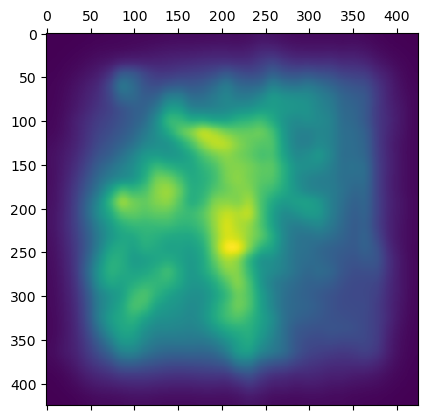

In [55]:
plt.matshow(gbvs_mat_s_mat[:,0].reshape(425,425))

In [53]:
for i in range(0,5): 
    plt.matshow
gbvs_mat_s_mat.shape

(180625, 30000)

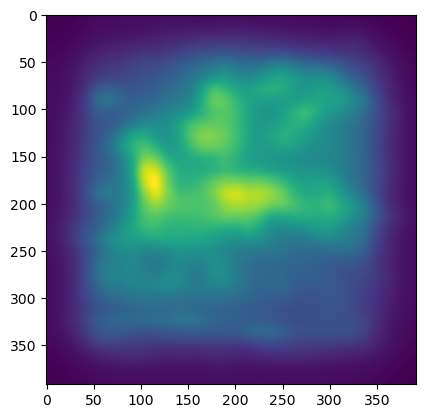

In [41]:
plt.imshow(mat['map_only'])

# UNISAL

Dependencies: 

`!pip install fire==0.2 tensorboardX==1.6`

In [7]:
from src.unisal import unisal

In [8]:
import fire

In [9]:
model = unisal.model.UNISAL()

/gpfs01/bartels/user/hbhatnagar/anaconda3/envs/NSD-Saliency/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484683044/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
model.load_best_weights(directory="/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/src/unisal/training_runs/pretrained_unisal")

In [15]:
imgs_test = image_data_73k[0:2]

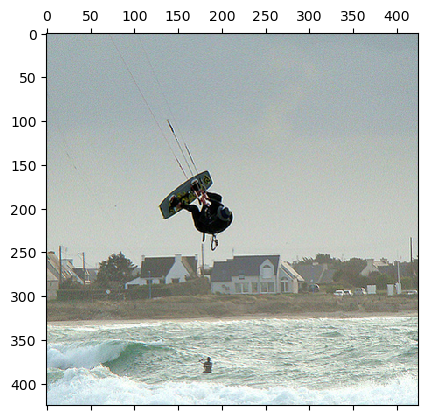

In [13]:
plt.matshow(img_test)

In [20]:
imgs_test.shape

(2, 425, 425, 3)

In [23]:
imgs_test = imgs_test.reshape(2,3,425,425)

In [ ]:
my_source = 'SALICON'
static = True

prediction = model(x = torch.tensor(imgs_test), target_size = (425, 425), source = my_source, static = static)

In [18]:
imgs_test.shape[-2:]

(425, 3)